In [1]:
!pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.6 MB/s eta 0:00:00


In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
from shapely.geometry import Point
import sys # Added to help print clear errors
import geopy.distance as distance  # Import the entire geopy.distance module as distance
from geopy.geocoders import Nominatim
# from geopy.distance import geodesic # Remove the direct import of geodesic
import time
from tqdm.notebook import tqdm
from typing import List
import category_encoders as ce
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from typing import Tuple
import xgboost as xgb

In [ ]:
data = pd.read_csv('City_MedianRentalPrice_1Bedroom (1).csv') #importing data set

In [ ]:
data #displaying the datafarme

,Unnamed: 0,RegionName,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,0,New York,NY,New York-Newark-Jersey City,Queens County,1,NaN,NaN,NaN,2250.0,...,2350.0,2400.0,2400.0,2450.0,2450.0,2475.0,2475.0,2400.0,2400.0,2425.0
1,1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,NaN,NaN,NaN,NaN,...,2360.0,2395.0,2370.0,2395.0,2395.0,2400.0,2425.0,2350.0,2330.0,2340.0
2,2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,NaN,NaN,NaN,NaN,...,1265.0,1270.0,1269.0,1286.0,1275.0,1275.0,1270.0,1264.0,1245.0,1249.0
3,3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,NaN,NaN,NaN,NaN,...,1695.0,1650.0,1650.0,1634.0,1600.0,1582.0,1595.0,1542.0,1550.0,1550.0
4,4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,NaN,NaN,NaN,NaN,...,985.0,981.0,985.0,999.0,1000.0,1000.0,991.0,985.0,974.5,967.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,813,Bee Cave,TX,Austin-Round Rock,Travis County,814,NaN,NaN,NaN,NaN,...,1185.0,1202.0,1179.0,1203.0,1264.0,1304.0,1326.0,1299.0,1250.0,1315.5
814,814,Century Village,FL,Miami-Fort Lauderdale-West Palm Beach,Palm Beach County,815,NaN,NaN,NaN,NaN,...,900.0,900.0,900.0,900.0,900.0,925.0,925.0,925.0,925.0,950.0
815,815,Surfside,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,816,NaN,NaN,NaN,NaN,...,1875.0,1850.0,1750.0,1800.0,1800.0,1750.0,1750.0,1800.0,1800.0,1850.0
816,816,Bay Harbor Islands,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,817,NaN,NaN,NaN,NaN,...,1565.0,1550.0,1512.5,1537.5,1600.0,1597.5,1550.0,1550.0,1550.0,1595.0


In [ ]:
# Get the list of column names
columns = data.columns.tolist()

# Define the number of columns per chunk
chunk_size = 10

# Create a list to store the DataFrames
column_chunks = []

# Iterate through the columns in chunks and create DataFrames
for i in range(0, len(columns), chunk_size):
    chunk_columns = columns[i:i + chunk_size]
    chunk_df = data[chunk_columns].copy() # Create a new DataFrame for the chunk
    column_chunks.append(chunk_df)
    print(f"Created DataFrame for columns {i} to {i + chunk_size - 1}")
    display(chunk_df.head()) # Display the head of each created DataFrame
    print("-" * 30) # Print a separator line

# Now you have a list of DataFrames in the 'column_chunks' variable

Created DataFrame for columns 0 to 9


,Unnamed: 0,RegionName,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05
0,0,New York,NY,New York-Newark-Jersey City,Queens County,1,NaN,NaN,NaN,2250.0
1,1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,NaN,NaN,NaN,NaN
2,2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,NaN,NaN,NaN,NaN
3,3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,NaN,NaN,NaN,NaN
4,4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,NaN,NaN,NaN,NaN


------------------------------
Created DataFrame for columns 10 to 19


,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03
0,2369.0,2300.0,2350.0,2500.0,2550.0,2499.0,2450.0,2200.0,2200.0,2400.0
1,NaN,NaN,NaN,NaN,1262.5,1267.5,1352.5,1295.0,1332.0,1350.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1355.0,1352.0,1394.5,1235.0,1275.0,1250.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,655.0,597.0,595.0


------------------------------
Created DataFrame for columns 20 to 29


,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01
0,2500.0,2500.0,2350.0,2300.0,2400.0,2300.0,2350.0,2430.0,2400.0,2400.0
1,1350.0,1362.5,1375.0,1350.0,1315.0,1290.0,1250.0,1250.0,1200.0,1275.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1283.5,1300.0,1375.0,1345.0,1300.0,1325.0,1329.0,1345.0,1381.0,1395.0
4,595.0,595.0,600.0,640.0,650.0,650.0,639.0,670.0,675.0,685.0


------------------------------
Created DataFrame for columns 30 to 39


,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11
0,2450.0,2495.0,2500.0,2500.0,2500.0,2500.0,2550.0,2595.0,2600.0,2600.0
1,1350.0,1400.0,1395.0,1420.0,1400.0,1395.0,1395.0,1450.0,1520.0,1528.5
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1341.0,1280.0,1250.0,1326.5,1395.0,1400.0,1400.0,1465.0,1500.0,1477.0
4,715.0,732.5,695.0,685.0,680.0,679.5,730.0,725.0,708.0,715.0


------------------------------
Created DataFrame for columns 40 to 49


,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09
0,2600.0,2595.0,2650.0,2613.0,2650.0,2699.0,2700.0,2640.5,2650.0,2700.0
1,1444.0,1450.0,1575.0,1588.0,1553.0,1550.0,1550.0,1475.0,1450.0,1495.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500.0,1500.0,1600.0,1500.0,1550.0,1582.0,1600.0,1590.0,1594.0,1569.0
4,695.0,711.0,715.0,734.0,750.0,730.0,731.0,729.0,750.0,760.0


------------------------------
Created DataFrame for columns 50 to 59


,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07
0,2700.0,2650.0,2619.0,2600.0,2600.0,2600.0,2600.0,2650.0,2640.0,2300.0
1,1502.0,1375.0,1525.0,1495.0,1490.0,1450.0,1495.0,1580.0,1595.0,1650.0
2,NaN,1260.0,1119.0,1224.0,1125.0,1072.0,1105.0,1210.0,1212.0,1234.5
3,1545.0,1588.0,1642.0,1620.0,1549.0,1510.0,1498.0,1495.0,1544.0,1638.0
4,775.0,775.0,790.0,799.0,800.0,800.0,800.0,775.0,796.0,786.0


------------------------------
Created DataFrame for columns 60 to 69


,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05
0,2250.0,2295.0,2250.0,2275.0,2200.0,2200.0,2250.0,2295.0,2350.0,2375.0
1,1695.0,1700.0,1750.0,1725.0,1775.0,1755.0,1795.0,1795.0,1750.0,1795.0
2,1200.0,1229.0,1245.0,1184.0,1199.0,1190.0,1200.0,1200.0,1225.0,1229.0
3,1525.0,1674.0,1700.0,1650.0,1495.0,1600.0,1658.0,1500.5,1500.0,1515.0
4,787.5,780.0,775.0,780.0,789.0,785.0,790.0,779.0,773.5,775.0


------------------------------
Created DataFrame for columns 70 to 79


,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03
0,2300.0,2250.0,2300.0,2300.0,2250.0,2200.0,2200.0,2200.0,2200.0,2200.0
1,1810.0,1800.0,1800.0,1845.0,1850.0,1852.0,1849.0,1990.0,1999.0,2021.0
2,1225.0,1225.0,1225.0,1240.0,1240.5,1357.5,1355.0,1374.0,1295.0,1325.0
3,1500.0,1480.0,1492.0,1645.0,1724.5,1804.0,1724.0,1680.0,1737.0,1595.0
4,775.0,783.0,795.0,795.0,800.0,850.0,850.0,825.0,820.0,850.0


------------------------------
Created DataFrame for columns 80 to 89


,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
0,2295.0,2300.0,2350.0,2350.0,2349.0,2400.0,2495.0,2400.0,2200.0,2250.0
1,2020.0,2006.5,1995.0,1959.5,1946.5,1995.0,1925.0,1930.0,1850.0,1966.0
2,1300.0,1295.0,1281.0,1239.0,1195.0,1230.0,1170.0,1109.0,1150.0,1200.0
3,1545.0,1535.0,1505.0,1488.0,1495.0,1495.0,1495.0,1550.0,1550.0,1532.0
4,825.0,800.0,820.0,804.0,820.0,834.0,790.0,807.0,779.5,810.0


------------------------------
Created DataFrame for columns 90 to 99


,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11
0,2300.0,2300.0,2350.0,2375.0,2395.0,2395.0,2400.0,2400.0,2350.0,2300.0
1,2020.0,2100.0,2078.0,2076.5,2098.0,2150.0,2100.0,2121.5,2120.5,2095.0
2,1230.0,1240.0,1250.0,1250.0,1220.0,1210.0,1229.0,1240.0,1250.0,1270.0
3,1500.0,1495.0,1495.0,1495.0,1495.0,1497.0,1525.0,1595.0,1610.0,1635.0
4,835.0,840.0,850.0,909.0,900.0,886.0,885.0,899.0,900.0,893.5


------------------------------
Created DataFrame for columns 100 to 109


,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
0,2300.0,2300.0,2300.0,2300.0,2399.0,2400.0,2400.0,2400.0,2400.0,2400.0
1,2095.0,2069.0,2100.0,2100.0,1995.0,2115.0,2225.0,2270.0,2332.0,2333.0
2,1283.5,1282.0,1308.0,1315.0,1315.0,1300.0,1300.0,1290.0,1292.0,1277.0
3,1596.0,1595.0,1595.0,1595.0,1600.0,1595.0,1595.0,1604.0,1614.0,1600.0
4,900.0,899.0,957.0,938.0,929.0,947.0,961.0,950.0,965.0,950.0


------------------------------
Created DataFrame for columns 110 to 119


,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07
0,2325.0,2300.0,2295.0,2300.0,2300.0,2350.0,2400.0,2400.0,2450.0,2450.0
1,2370.0,2350.0,2354.0,2362.5,2345.0,2360.0,2395.0,2370.0,2395.0,2395.0
2,1272.0,1279.0,1265.0,1250.0,1250.0,1265.0,1270.0,1269.0,1286.0,1275.0
3,1595.0,1626.0,1640.0,1670.0,1675.0,1695.0,1650.0,1650.0,1634.0,1600.0
4,945.0,958.5,945.0,952.0,983.0,985.0,981.0,985.0,999.0,1000.0


------------------------------
Created DataFrame for columns 120 to 129


,2019-08,2019-09,2019-10,2019-11,2019-12
0,2475.0,2475.0,2400.0,2400.0,2425.0
1,2400.0,2425.0,2350.0,2330.0,2340.0
2,1275.0,1270.0,1264.0,1245.0,1249.0
3,1582.0,1595.0,1542.0,1550.0,1550.0
4,1000.0,991.0,985.0,974.5,967.5


------------------------------


In [ ]:
column_chunks[0]

,Unnamed: 0,RegionName,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05
0,0,New York,NY,New York-Newark-Jersey City,Queens County,1,NaN,NaN,NaN,2250.0
1,1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,NaN,NaN,NaN,NaN
2,2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,NaN,NaN,NaN,NaN
3,3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,NaN,NaN,NaN,NaN
4,4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
813,813,Bee Cave,TX,Austin-Round Rock,Travis County,814,NaN,NaN,NaN,NaN
814,814,Century Village,FL,Miami-Fort Lauderdale-West Palm Beach,Palm Beach County,815,NaN,NaN,NaN,NaN
815,815,Surfside,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,816,NaN,NaN,NaN,NaN
816,816,Bay Harbor Islands,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,817,NaN,NaN,NaN,NaN


In [ ]:
column_chunks[0].isna().sum()

,0
Unnamed: 0,0
RegionName,0
State,0
Metro,0
CountyName,0
SizeRank,0
2010-02,815
2010-03,815
2010-04,815
2010-05,814


In [ ]:
data.drop(['2010-02','2010-03','2010-04','2010-05'], inplace=True,axis=1)

In [ ]:
column_chunks[1]

,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03
0,2369.0,2300.0,2350.0,2500.0,2550.0,2499.0,2450.0,2200.0,2200.0,2400.0
1,NaN,NaN,NaN,NaN,1262.5,1267.5,1352.5,1295.0,1332.0,1350.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1355.0,1352.0,1394.5,1235.0,1275.0,1250.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,655.0,597.0,595.0
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_chunks[1].isna().sum()

,0
2010-06,814
2010-07,814
2010-08,814
2010-09,810
2010-10,806
2010-11,805
2010-12,805
2011-01,794
2011-02,774
2011-03,774


In [ ]:
data.drop(column_chunks[1], inplace=True,axis=1)

In [ ]:
column_chunks[2]

,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01
0,2500.0,2500.0,2350.0,2300.0,2400.0,2300.0,2350.0,2430.0,2400.0,2400.0
1,1350.0,1362.5,1375.0,1350.0,1315.0,1290.0,1250.0,1250.0,1200.0,1275.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1283.5,1300.0,1375.0,1345.0,1300.0,1325.0,1329.0,1345.0,1381.0,1395.0
4,595.0,595.0,600.0,640.0,650.0,650.0,639.0,670.0,675.0,685.0
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_chunks[2].isna().sum()

,0
2011-04,772
2011-05,769
2011-06,761
2011-07,753
2011-08,748
2011-09,739
2011-10,729
2011-11,719
2011-12,714
2012-01,708


In [ ]:
data.drop(column_chunks[2], inplace=True,axis=1)

In [ ]:
column_chunks[3]

,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11
0,2450.0,2495.0,2500.0,2500.0,2500.0,2500.0,2550.0,2595.0,2600.0,2600.0
1,1350.0,1400.0,1395.0,1420.0,1400.0,1395.0,1395.0,1450.0,1520.0,1528.5
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1341.0,1280.0,1250.0,1326.5,1395.0,1400.0,1400.0,1465.0,1500.0,1477.0
4,715.0,732.5,695.0,685.0,680.0,679.5,730.0,725.0,708.0,715.0
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_chunks[3].isna().sum()

,0
2012-02,705
2012-03,702
2012-04,702
2012-05,700
2012-06,698
2012-07,694
2012-08,691
2012-09,690
2012-10,689
2012-11,687


In [ ]:
data.drop(column_chunks[3], inplace=True,axis=1)

In [ ]:
column_chunks[4]

,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09
0,2600.0,2595.0,2650.0,2613.0,2650.0,2699.0,2700.0,2640.5,2650.0,2700.0
1,1444.0,1450.0,1575.0,1588.0,1553.0,1550.0,1550.0,1475.0,1450.0,1495.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500.0,1500.0,1600.0,1500.0,1550.0,1582.0,1600.0,1590.0,1594.0,1569.0
4,695.0,711.0,715.0,734.0,750.0,730.0,731.0,729.0,750.0,760.0
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_chunks[4].isna().sum()

,0
2012-12,687
2013-01,687
2013-02,684
2013-03,684
2013-04,684
2013-05,683
2013-06,682
2013-07,682
2013-08,682
2013-09,682


In [ ]:
data.drop(column_chunks[4], inplace=True,axis=1)

In [ ]:
column_chunks[5]

,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07
0,2700.0,2650.0,2619.0,2600.0,2600.0,2600.0,2600.0,2650.0,2640.0,2300.0
1,1502.0,1375.0,1525.0,1495.0,1490.0,1450.0,1495.0,1580.0,1595.0,1650.0
2,NaN,1260.0,1119.0,1224.0,1125.0,1072.0,1105.0,1210.0,1212.0,1234.5
3,1545.0,1588.0,1642.0,1620.0,1549.0,1510.0,1498.0,1495.0,1544.0,1638.0
4,775.0,775.0,790.0,799.0,800.0,800.0,800.0,775.0,796.0,786.0
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_chunks[5].isna().sum()

,0
2013-10,680
2013-11,675
2013-12,675
2014-01,668
2014-02,664
2014-03,663
2014-04,663
2014-05,662
2014-06,658
2014-07,656


In [ ]:
data.drop(column_chunks[5], inplace=True,axis=1)

In [ ]:
column_chunks[6]

,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05
0,2250.0,2295.0,2250.0,2275.0,2200.0,2200.0,2250.0,2295.0,2350.0,2375.0
1,1695.0,1700.0,1750.0,1725.0,1775.0,1755.0,1795.0,1795.0,1750.0,1795.0
2,1200.0,1229.0,1245.0,1184.0,1199.0,1190.0,1200.0,1200.0,1225.0,1229.0
3,1525.0,1674.0,1700.0,1650.0,1495.0,1600.0,1658.0,1500.5,1500.0,1515.0
4,787.5,780.0,775.0,780.0,789.0,785.0,790.0,779.0,773.5,775.0
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_chunks[6].isna().sum()

,0
2014-08,653
2014-09,651
2014-10,648
2014-11,647
2014-12,643
2015-01,639
2015-02,633
2015-03,630
2015-04,629
2015-05,629


In [ ]:
data.drop(column_chunks[6], inplace=True,axis=1)

In [ ]:
column_chunks[7]

,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03
0,2300.0,2250.0,2300.0,2300.0,2250.0,2200.0,2200.0,2200.0,2200.0,2200.0
1,1810.0,1800.0,1800.0,1845.0,1850.0,1852.0,1849.0,1990.0,1999.0,2021.0
2,1225.0,1225.0,1225.0,1240.0,1240.5,1357.5,1355.0,1374.0,1295.0,1325.0
3,1500.0,1480.0,1492.0,1645.0,1724.5,1804.0,1724.0,1680.0,1737.0,1595.0
4,775.0,783.0,795.0,795.0,800.0,850.0,850.0,825.0,820.0,850.0
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_chunks[7].isna().sum()

,0
2015-06,628
2015-07,627
2015-08,626
2015-09,624
2015-10,622
2015-11,620
2015-12,614
2016-01,611
2016-02,606
2016-03,603


In [ ]:
data.drop(column_chunks[7], inplace=True,axis=1)

In [ ]:
column_chunks[8]

,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
0,2295.0,2300.0,2350.0,2350.0,2349.0,2400.0,2495.0,2400.0,2200.0,2250.0
1,2020.0,2006.5,1995.0,1959.5,1946.5,1995.0,1925.0,1930.0,1850.0,1966.0
2,1300.0,1295.0,1281.0,1239.0,1195.0,1230.0,1170.0,1109.0,1150.0,1200.0
3,1545.0,1535.0,1505.0,1488.0,1495.0,1495.0,1495.0,1550.0,1550.0,1532.0
4,825.0,800.0,820.0,804.0,820.0,834.0,790.0,807.0,779.5,810.0
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,850.0
815,NaN,NaN,NaN,NaN,NaN,1800.0,1800.0,1900.0,1799.5,1825.0
816,NaN,NaN,NaN,NaN,NaN,1400.0,1500.0,1500.0,1550.0,1450.0


In [ ]:
column_chunks[8].isna().sum()

,0
2016-04,600
2016-05,595
2016-06,588
2016-07,587
2016-08,584
2016-09,575
2016-10,568
2016-11,556
2016-12,534
2017-01,422


In [ ]:
data.drop(column_chunks[8], inplace=True,axis=1)

In [ ]:
column_chunks[9]

,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11
0,2300.0,2300.0,2350.0,2375.0,2395.0,2395.0,2400.0,2400.0,2350.0,2300.0
1,2020.0,2100.0,2078.0,2076.5,2098.0,2150.0,2100.0,2121.5,2120.5,2095.0
2,1230.0,1240.0,1250.0,1250.0,1220.0,1210.0,1229.0,1240.0,1250.0,1270.0
3,1500.0,1495.0,1495.0,1495.0,1495.0,1497.0,1525.0,1595.0,1610.0,1635.0
4,835.0,840.0,850.0,909.0,900.0,886.0,885.0,899.0,900.0,893.5
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,850.0,875.0,875.0,875.0,875.0,850.0,850.0,850.0,850.0,850.0
815,1925.0,1750.0,1750.0,1800.0,1825.0,1800.0,1825.0,1800.0,1800.0,1800.0
816,1600.0,1550.0,1500.0,1475.0,1495.0,1550.0,1575.0,1550.0,1500.0,1497.5


In [ ]:
column_chunks[9].isna().sum()

,0
2017-02,381
2017-03,352
2017-04,334
2017-05,311
2017-06,301
2017-07,290
2017-08,277
2017-09,270
2017-10,260
2017-11,250


In [ ]:
data.drop(column_chunks[9], inplace=True,axis=1)

In [ ]:
column_chunks[10]

,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
0,2300.0,2300.0,2300.0,2300.0,2399.0,2400.0,2400.0,2400.0,2400.0,2400.0
1,2095.0,2069.0,2100.0,2100.0,1995.0,2115.0,2225.0,2270.0,2332.0,2333.0
2,1283.5,1282.0,1308.0,1315.0,1315.0,1300.0,1300.0,1290.0,1292.0,1277.0
3,1596.0,1595.0,1595.0,1595.0,1600.0,1595.0,1595.0,1604.0,1614.0,1600.0
4,900.0,899.0,957.0,938.0,929.0,947.0,961.0,950.0,965.0,950.0
...,...,...,...,...,...,...,...,...,...,...
813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1234.0,1227.0,1218.0
814,850.0,850.0,850.0,875.0,875.0,900.0,900.0,900.0,900.0,900.0
815,1800.0,1725.0,1750.0,1750.0,1812.5,1800.0,1875.0,1975.0,2000.0,1937.5
816,1500.0,1475.0,1500.0,1490.0,1487.5,1500.0,1500.0,1500.0,1550.0,1500.0


In [ ]:
column_chunks[10].isna().sum()

,0
2017-12,229
2018-01,200
2018-02,178
2018-03,163
2018-04,152
2018-05,137
2018-06,131
2018-07,119
2018-08,102
2018-09,91


In [ ]:
column_chunks[11].isna().sum()

,0
2018-10,52
2018-11,42
2018-12,22
2019-01,0
2019-02,0
2019-03,0
2019-04,0
2019-05,0
2019-06,0
2019-07,0


In [ ]:
column_chunks[12].isna().sum()

,0
2019-08,0
2019-09,0
2019-10,0
2019-11,0
2019-12,0


In [ ]:
column_chunks[10].isna().sum()

,0
2017-12,229
2018-01,200
2018-02,178
2018-03,163
2018-04,152
2018-05,137
2018-06,131
2018-07,119
2018-08,102
2018-09,91


In [ ]:
data.drop(['2017-12','2018-01', '2018-02', '2018-03', '2018-04'] ,inplace=True,axis=1)

In [ ]:
#seeing all the columns that has nulls and drop what we want from this columns

In [ ]:
data.dropna(inplace=True) #droping the rows with nulls after leaving the suitable columns

In [ ]:
data

,Unnamed: 0,RegionName,State,Metro,CountyName,SizeRank,2018-05,2018-06,2018-07,2018-08,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,0,New York,NY,New York-Newark-Jersey City,Queens County,1,2400.0,2400.0,2400.0,2400.0,...,2350.0,2400.0,2400.0,2450.0,2450.0,2475.0,2475.0,2400.0,2400.0,2425.0
1,1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2115.0,2225.0,2270.0,2332.0,...,2360.0,2395.0,2370.0,2395.0,2395.0,2400.0,2425.0,2350.0,2330.0,2340.0
2,2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1300.0,1300.0,1290.0,1292.0,...,1265.0,1270.0,1269.0,1286.0,1275.0,1275.0,1270.0,1264.0,1245.0,1249.0
3,3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1595.0,1595.0,1604.0,1614.0,...,1695.0,1650.0,1650.0,1634.0,1600.0,1582.0,1595.0,1542.0,1550.0,1550.0
4,4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,947.0,961.0,950.0,965.0,...,985.0,981.0,985.0,999.0,1000.0,1000.0,991.0,985.0,974.5,967.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,812,West Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,813,1875.0,1875.0,1845.0,1860.0,...,1825.0,1825.0,1817.0,1803.0,1789.0,1790.0,1798.0,1819.0,1805.0,1823.0
814,814,Century Village,FL,Miami-Fort Lauderdale-West Palm Beach,Palm Beach County,815,900.0,900.0,900.0,900.0,...,900.0,900.0,900.0,900.0,900.0,925.0,925.0,925.0,925.0,950.0
815,815,Surfside,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,816,1800.0,1875.0,1975.0,2000.0,...,1875.0,1850.0,1750.0,1800.0,1800.0,1750.0,1750.0,1800.0,1800.0,1850.0
816,816,Bay Harbor Islands,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,817,1500.0,1500.0,1500.0,1550.0,...,1565.0,1550.0,1512.5,1537.5,1600.0,1597.5,1550.0,1550.0,1550.0,1595.0


In [ ]:
data.isna().sum() # now the data is cleaned from nulls

,0
Unnamed: 0,0
RegionName,0
State,0
Metro,0
CountyName,0
SizeRank,0
2018-05,0
2018-06,0
2018-07,0
2018-08,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 681 entries, 0 to 817
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  681 non-null    int64  
 1   RegionName  681 non-null    object 
 2   State       681 non-null    object 
 3   Metro       681 non-null    object 
 4   CountyName  681 non-null    object 
 5   SizeRank    681 non-null    int64  
 6   2018-05     681 non-null    float64
 7   2018-06     681 non-null    float64
 8   2018-07     681 non-null    float64
 9   2018-08     681 non-null    float64
 10  2018-09     681 non-null    float64
 11  2018-10     681 non-null    float64
 12  2018-11     681 non-null    float64
 13  2018-12     681 non-null    float64
 14  2019-01     681 non-null    float64
 15  2019-02     681 non-null    float64
 16  2019-03     681 non-null    float64
 17  2019-04     681 non-null    float64
 18  2019-05     681 non-null    float64
 19  2019-06     681 non-null    float6

In [ ]:
data.describe()

,Unnamed: 0,SizeRank,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
count,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,...,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000
mean,387.365639,388.364170,1361.491189,1369.331865,1373.718062,1377.765786,1369.756975,1371.337004,1372.803965,1367.997063,...,1388.323054,1396.156388,1404.521292,1413.521292,1414.059471,1411.566814,1409.433186,1406.098385,1404.838473,1408.840675
std,234.637323,234.637661,526.986243,533.474973,537.448929,535.992099,530.727689,529.542313,535.805413,533.501618,...,541.582660,537.779421,541.953007,547.429568,548.109638,548.421445,549.080325,541.406822,541.576769,541.681654
min,0.000000,1.000000,442.500000,402.500000,395.000000,395.000000,400.000000,410.000000,425.000000,425.000000,...,450.000000,475.000000,475.000000,425.000000,425.000000,420.000000,425.000000,425.000000,425.000000,425.000000
25%,184.000000,185.000000,995.000000,995.000000,995.000000,1000.000000,999.500000,999.000000,1000.000000,999.000000,...,1005.500000,1022.500000,1035.000000,1044.000000,1050.000000,1043.000000,1032.500000,1028.000000,1036.000000,1047.500000
50%,379.000000,380.000000,1289.000000,1296.000000,1298.000000,1300.000000,1300.000000,1304.000000,1300.000000,1294.000000,...,1320.000000,1340.000000,1344.000000,1350.000000,1350.000000,1339.000000,1343.000000,1344.500000,1340.000000,1340.000000
75%,584.000000,585.000000,1660.000000,1671.500000,1670.000000,1672.000000,1650.000000,1659.000000,1662.000000,1659.500000,...,1695.000000,1678.000000,1691.500000,1703.000000,1705.000000,1700.000000,1709.500000,1700.000000,1695.000000,1699.500000
max,817.000000,818.000000,4235.000000,4500.000000,5000.000000,4550.000000,4500.000000,4500.000000,5195.000000,4995.000000,...,4900.000000,5000.000000,5000.000000,5000.000000,5000.000000,4900.000000,5000.000000,5000.000000,5000.000000,5000.000000


In [ ]:
data[['2019-01','2019-02']].describe()

,2019-01,2019-02
count,681.000000,681.000000
mean,1369.765051,1376.900881
std,532.191539,538.320064
min,425.000000,425.000000
25%,999.000000,1000.000000
50%,1310.000000,1299.500000
75%,1668.000000,1675.000000
max,4895.000000,5000.000000


In [ ]:
data

,Unnamed: 0,RegionName,State,Metro,CountyName,SizeRank,2018-05,2018-06,2018-07,2018-08,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,0,New York,NY,New York-Newark-Jersey City,Queens County,1,2400.0,2400.0,2400.0,2400.0,...,2350.0,2400.0,2400.0,2450.0,2450.0,2475.0,2475.0,2400.0,2400.0,2425.0
1,1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2115.0,2225.0,2270.0,2332.0,...,2360.0,2395.0,2370.0,2395.0,2395.0,2400.0,2425.0,2350.0,2330.0,2340.0
2,2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1300.0,1300.0,1290.0,1292.0,...,1265.0,1270.0,1269.0,1286.0,1275.0,1275.0,1270.0,1264.0,1245.0,1249.0
3,3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1595.0,1595.0,1604.0,1614.0,...,1695.0,1650.0,1650.0,1634.0,1600.0,1582.0,1595.0,1542.0,1550.0,1550.0
4,4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,947.0,961.0,950.0,965.0,...,985.0,981.0,985.0,999.0,1000.0,1000.0,991.0,985.0,974.5,967.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,812,West Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,813,1875.0,1875.0,1845.0,1860.0,...,1825.0,1825.0,1817.0,1803.0,1789.0,1790.0,1798.0,1819.0,1805.0,1823.0
814,814,Century Village,FL,Miami-Fort Lauderdale-West Palm Beach,Palm Beach County,815,900.0,900.0,900.0,900.0,...,900.0,900.0,900.0,900.0,900.0,925.0,925.0,925.0,925.0,950.0
815,815,Surfside,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,816,1800.0,1875.0,1975.0,2000.0,...,1875.0,1850.0,1750.0,1800.0,1800.0,1750.0,1750.0,1800.0,1800.0,1850.0
816,816,Bay Harbor Islands,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,817,1500.0,1500.0,1500.0,1550.0,...,1565.0,1550.0,1512.5,1537.5,1600.0,1597.5,1550.0,1550.0,1550.0,1595.0


In [ ]:
data['CountyName'].nunique()

255

In [ ]:
data['RegionName'].nunique()

645

In [ ]:
data['State'].nunique()

50

In [ ]:
data['Metro'].nunique()

173

In [ ]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
display(data.head())

,RegionName,State,Metro,CountyName,SizeRank,2018-05,2018-06,2018-07,2018-08,2018-09,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,New York,NY,New York-Newark-Jersey City,Queens County,1,2400.0,2400.0,2400.0,2400.0,2400.0,...,2350.0,2400.0,2400.0,2450.0,2450.0,2475.0,2475.0,2400.0,2400.0,2425.0
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2115.0,2225.0,2270.0,2332.0,2333.0,...,2360.0,2395.0,2370.0,2395.0,2395.0,2400.0,2425.0,2350.0,2330.0,2340.0
2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1300.0,1300.0,1290.0,1292.0,1277.0,...,1265.0,1270.0,1269.0,1286.0,1275.0,1275.0,1270.0,1264.0,1245.0,1249.0
3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1595.0,1595.0,1604.0,1614.0,1600.0,...,1695.0,1650.0,1650.0,1634.0,1600.0,1582.0,1595.0,1542.0,1550.0,1550.0
4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,947.0,961.0,950.0,965.0,950.0,...,985.0,981.0,985.0,999.0,1000.0,1000.0,991.0,985.0,974.5,967.5


In [ ]:
from scipy.stats import zscore

# Calculate the z-scores for the '2019-12' column
data['2019-12_zscore'] = zscore(data['2019-12'])

# Define a z-score threshold (a common threshold is 3)
zscore_threshold = 3
# Identify the outliers
outliers = data[abs(data['2019-12_zscore']) > zscore_threshold]

# Display the outliers
print(f"Outliers in '2019-12' based on a z-score threshold of {zscore_threshold}:")
print("Number of outliers using Z-score method:", outliers.shape[0])
display(outliers)

Outliers in '2019-12' based on a z-score threshold of 3:
Number of outliers using Z-score method: 4


,RegionName,State,Metro,CountyName,SizeRank,2018-05,2018-06,2018-07,2018-08,2018-09,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2019-12_zscore
14,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,15,3429.5,3475.0,3476.5,3495.0,3495.0,...,3534.0,3600.0,3641.5,3615.0,3600.0,3650.0,3580.0,3499.0,3500.0,3.863333
407,Mountain View,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,408,2951.5,3300.0,2997.5,2886.0,2885.5,...,2794.5,2900.0,3095.0,3263.5,3675.0,3631.0,3675.0,3646.5,3350.0,3.586214
677,Foster City,CA,San Francisco-Oakland-Hayward,San Mateo County,678,3089.0,2984.5,3068.0,3027.5,3001.5,...,3271.0,3298.0,3334.5,3312.0,3215.0,3088.0,2996.0,3053.5,3085.0,3.096637
767,Malibu,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,768,4235.0,4500.0,5000.0,4550.0,4500.0,...,5000.0,5000.0,5000.0,5000.0,4900.0,5000.0,5000.0,5000.0,5000.0,6.634522


In [ ]:
outliers['2019-12']

,2019-12
14,3500.0
407,3350.0
677,3085.0
767,5000.0


In [ ]:
# Calculate Q1 and Q3 for the '2019-12' column
Q1 = data['2019-12'].quantile(0.25)
Q3 = data['2019-12'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5* IQR

# Identify the outliers using the IQR method
outliers_iqr = data[(data['2019-12'] < lower_bound) | (data['2019-12'] > upper_bound)]

# Display the outliers
print(f"Outliers in '2019-12' based on the IQR method (1.5 * IQR):")
print("Number of outliers using IQR method:", outliers_iqr.shape[0])
display(outliers_iqr)

Outliers in '2019-12' based on the IQR method (1.5 * IQR):
Number of outliers using IQR method: 16


,RegionName,State,Metro,CountyName,SizeRank,2018-05,2018-06,2018-07,2018-08,2018-09,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2019-12_zscore
14,San Francisco,CA,San Francisco-Oakland-Hayward,San Francisco County,15,3429.5,3475.0,3476.5,3495.0,3495.0,...,3534.0,3600.0,3641.5,3615.0,3600.0,3650.0,3580.0,3499.0,3500.0,3.863333
44,Oakland,CA,San Francisco-Oakland-Hayward,Alameda County,45,2275.0,2225.0,2200.0,2295.0,2395.0,...,3055.0,3063.0,3125.0,3146.0,3170.0,3075.0,2939.5,2875.0,2970.0,2.884179
298,San Mateo,CA,San Francisco-Oakland-Hayward,San Mateo County,299,2929.0,2961.5,3000.5,2962.5,2799.0,...,2925.0,2988.0,2998.0,2976.0,2940.0,2980.0,2832.5,2700.0,2720.0,2.422314
333,Santa Monica,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,334,2760.0,2700.0,2700.0,2978.5,2995.0,...,2995.0,2990.0,2895.0,2995.0,3000.0,2995.0,2995.0,2975.0,3000.0,2.939603
407,Mountain View,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,408,2951.5,3300.0,2997.5,2886.0,2885.5,...,2794.5,2900.0,3095.0,3263.5,3675.0,3631.0,3675.0,3646.5,3350.0,3.586214
467,Palo Alto,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,468,2815.0,2752.5,2755.0,2750.0,2957.5,...,2750.0,2692.5,2950.0,2995.0,3000.0,3172.5,2995.0,2950.0,2800.0,2.570111
518,Cupertino,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,519,3530.0,3530.0,3320.0,3085.0,3012.5,...,2858.0,2797.5,2852.0,2869.0,2826.5,2837.5,2707.0,2750.0,2825.0,2.616297
639,Great Neck,NY,New York-Newark-Jersey City,Nassau County,640,2450.0,2550.0,2700.0,2700.0,2700.0,...,2650.0,2800.0,2600.0,2650.0,2650.0,2650.0,2550.0,2800.0,2800.0,2.570111
664,Los Gatos,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,665,2495.0,2676.0,2807.0,2653.5,2745.0,...,2395.0,2550.0,2525.0,2595.0,2381.5,2632.0,2656.5,2550.0,2764.0,2.503602
667,Beverly Hills,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,668,2497.5,2500.0,2599.0,2572.5,2650.0,...,2795.0,2695.0,2695.0,2695.0,2695.0,2695.0,2695.0,2650.0,2795.0,2.560873


In [ ]:
outliers_iqr['2019-12']

,2019-12
14,3500.0
44,2970.0
298,2720.0
333,3000.0
407,3350.0
467,2800.0
518,2825.0
639,2800.0
664,2764.0
667,2795.0


In [ ]:
NoOutliersDataIqr= data.drop(outliers_iqr.index)
NoOutliersDataZscore= data.drop(outliers.index)

In [ ]:
print(data.shape)
print(NoOutliersDataIqr.shape)
print(NoOutliersDataZscore.shape)

(681, 26)
(665, 26)
(677, 26)


In [ ]:
print(data['2019-12'].max())
print(NoOutliersDataIqr['2019-12'].max())
print(NoOutliersDataZscore['2019-12'].max())

5000.0
2660.0
3000.0


In [ ]:
print(data['2019-12'].min())
print(NoOutliersDataIqr['2019-12'].min())
print(NoOutliersDataZscore['2019-12'].min()) #from my opinion I concluded that NoOutliersDataZscore is the most suitable

425.0
425.0
425.0


In [ ]:
# LocationData = data[['RegionName','State','CountyName']]

In [ ]:
# LocationData.to_csv('LocationData.csv', index=False) # index=False prevents writing the DataFrame index as a column in the CSV

In [ ]:
# import pandas as pd
# from geopy.geocoders import Nominatim
# from geopy.exc import GeocoderTimedOut, GeocoderServiceError
# import time
# from tqdm import tqdm


# LocWithCoordsData = pd.read_csv("LocationData.csv")
# LocWithCoordsData = LocWithCoordsData.iloc[:, 0:20]

# LocWithCoordsData["Latitude"] = None
# LocWithCoordsData["Longitude"] = None

# # Initialize the Nominatim geocoder with a custom user agent
# geolocator = Nominatim(user_agent="city_county_geocoder")

# def get_coordinates(city, county, state):
#     """
#     Geocodes a location based on city, county, and state.
#     Returns a tuple of (latitude, longitude).
#     """
#     try:
#         # Prioritize geocoding by city and state for better accuracy
#         address = f"{city}, {state}, USA"
#         location = geolocator.geocode(address, timeout=10)

#         # If city/state is not found, try geocoding by county
#         if not location:
#             address = f"{county}, {state}, USA"
#             location = geolocator.geocode(address, timeout=10)

#         if location:
#             return (location.latitude, location.longitude)
#         else:
#             return (None, None)
#     except (GeocoderTimedOut, GeocoderServiceError) as e:
#         print(f"Error geocoding {city}, {state}: {e}")
#         return (None, None)

# # Apply the geocoding function to each row of the DataFrame
# for idx, row in tqdm(LocWithCoordsData.iterrows(), total=LocWithCoordsData.shape[0]):
#     lat, lon = get_coordinates(row['RegionName'], row['CountyName'], row['State'])
#     print(f"{row['RegionName']} → {lat}, {lon}")
#     LocWithCoordsData.at[idx, "Latitude"] = lat
#     LocWithCoordsData.at[idx, "Longitude"] = lon
#     time.sleep(1.1) # Added delay

# # Print the final DataFrame with coordinates
# print(LocWithCoordsData.head())

# # save the new file
# LocWithCoordsData.to_csv("LocationData_with_coords.csv", index=False)

# print("تم حفظ الملف LocationData_with_coords.csv")

In [ ]:
LocWithCoordsData.head()

,RegionName,State,CountyName,Latitude,Longitude
0,New York,NY,Queens County,40.712728,-74.006015
1,Los Angeles,CA,Los Angeles County,34.053691,-118.242766
2,Houston,TX,Harris County,29.758938,-95.367697
3,Chicago,IL,Cook County,41.875562,-87.624421
4,San Antonio,TX,Bexar County,29.424600,-98.495141


In [ ]:
LocWithCoordsData = pd.read_csv("LocationData_with_coords.csv")

# Drop duplicates based on RegionName, keeping the first occurrence
LocWithCoordsData.drop_duplicates(subset=['RegionName'], keep='first', inplace=True)

In [ ]:
# Select only the RegionName, Latitude, and Longitude columns from LocWithCoordsData for merging
loc_cols_to_merge = LocWithCoordsData[['RegionName', 'Latitude', 'Longitude']]

# Merge the dataframes based on RegionName
data = pd.merge(data, loc_cols_to_merge, on='RegionName', how='left')

# Display the first few rows of the merged dataframe
display(data.head())

,RegionName,State,Metro,CountyName,SizeRank,2018-05,2018-06,2018-07,2018-08,2018-09,...,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2019-12_zscore,Latitude,Longitude
0,New York,NY,New York-Newark-Jersey City,Queens County,1,2400.0,2400.0,2400.0,2400.0,2400.0,...,2450.0,2450.0,2475.0,2475.0,2400.0,2400.0,2425.0,1.877313,40.712728,-74.006015
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2115.0,2225.0,2270.0,2332.0,2333.0,...,2395.0,2395.0,2400.0,2425.0,2350.0,2330.0,2340.0,1.720279,34.053691,-118.242766
2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1300.0,1300.0,1290.0,1292.0,1277.0,...,1286.0,1275.0,1275.0,1270.0,1264.0,1245.0,1249.0,-0.295299,29.758938,-95.367697
3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1595.0,1595.0,1604.0,1614.0,1600.0,...,1634.0,1600.0,1582.0,1595.0,1542.0,1550.0,1550.0,0.260786,41.875562,-87.624421
4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,947.0,961.0,950.0,965.0,950.0,...,999.0,1000.0,1000.0,991.0,985.0,974.5,967.5,-0.815359,29.424600,-98.495141


In [ ]:
data.drop(['2019-12_zscore'], axis=1, inplace=True)

In [ ]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time
from tqdm.notebook import tqdm # Import tqdm from notebook

geolocator = Nominatim(user_agent="geocoder")

# Calculate the geographical center of the continental United States
us_center = geolocator.geocode("Center, Kansas, USA") # A commonly accepted geographical center
if us_center:
    us_coords = (us_center.latitude, us_center.longitude)
    print(f"Geographical center of the US: {us_coords}")
else:
    us_coords = None
    print("Could not determine the geographical center of the US.")

# Calculate the geographical center for each state in the data
state_centers = {}
for state in tqdm(data['State'].unique(), desc="Geocoding State Centers"):
    try:
        # Attempt to geocode the state center
        location = geolocator.geocode(f"center of {state}, USA", timeout=10)
        if location:
            state_centers[state] = (location.latitude, location.longitude)
            print(f"Geographical center of {state}: {state_centers[state]}")
        else:
            # If state center is not found, try geocoding the state name
            location = geolocator.geocode(f"{state}, USA", timeout=10)
            if location:
                state_centers[state] = (location.latitude, location.longitude)
                print(f"Geocoding of {state} as a fallback: {state_centers[state]}")
            else:
                state_centers[state] = None
                print(f"Could not determine location for {state}. Skipping for now.")
    except Exception as e:
        state_centers[state] = None
        print(f"Error geocoding center of {state}: {e}")
    time.sleep(1.1) # Add a small delay to avoid overwhelming the geocoding service

# Calculate the geographical center for each county in the data
county_centers = {}
# Get unique CountyNames from the DataFrame
unique_counties = data['CountyName'].unique()
for county in tqdm(unique_counties, desc="Geocoding County Centers"):
    try:
        # Attempt to geocode the county by name and state
        county_state_combinations = data[data['CountyName'] == county]['State'].unique()
        if len(county_state_combinations) > 0:
            # Taking the first state for simplicity, assuming county names are unique within states in this dataset
            state = county_state_combinations[0]
            location = geolocator.geocode(f"{county}, {state}, USA", timeout=10)
            if location:
                county_centers[county] = (location.latitude, location.longitude)
                print(f"Geographical center of {county}, {state}: {county_centers[county]}")
            else:
                county_centers[county] = None
                print(f"Could not determine the geographical center of {county}, {state}. Skipping for now.")
        else:
             county_centers[county] = None
             print(f"Could not determine the state for county {county}. Skipping for now.")
    except Exception as e: # Catching generic Exception
        county_centers[county] = None
        print(f"Error geocoding center of {county}: {e}")
    time.sleep(1.1) # Add a small delay

Geographical center of the US: (37.9062172, -95.1898159)


Geocoding State Centers:   0%|          | 0/50 [00:00<?, ?it/s]

Geographical center of NY: (43.0692264, -76.1724895)
Geographical center of CA: (34.2727885, -119.2609533)
Geographical center of TX: (30.7049562, -97.7456235)
Geocoding of IL as a fallback: (40.0796606, -89.4337288)
Geographical center of PA: (30.5533195, -88.1496817)
Geographical center of AZ: (33.6437994, -111.8991554)
Geocoding of NV as a fallback: (39.5158825, -116.853722)
Geocoding of FL as a fallback: (27.7567667, -81.4639835)
Geographical center of IN: (34.0657497, -118.2367512)
Geographical center of NC: (42.2887914, -83.7140491)
Geocoding of OH as a fallback: (40.2253569, -82.6881395)
Geographical center of KY: (37.142278, -85.693025)
Geographical center of CO: (34.2727885, -119.2609533)
Geographical center of WA: (47.7288513, -122.2432612)
Geographical center of TN: (47.7288513, -122.2432612)
Geographical center of MA: (34.2727885, -119.2609533)
Geographical center of DC: (38.865504, -76.9893132)
Geocoding of OR as a fallback: (43.9792797, -120.737257)
Geographical center of

Geocoding County Centers:   0%|          | 0/255 [00:00<?, ?it/s]

Geographical center of Queens County, NY: (40.6515585, -73.7926754)
Geographical center of Los Angeles County, CA: (34.3155072, -118.209681)
Geographical center of Harris County, TX: (29.8119769, -95.3741247)
Geographical center of Cook County, IL: (41.8197385, -87.756525)
Geographical center of Bexar County, TX: (29.4263987, -98.5104781)
Geographical center of Philadelphia County, PA: (40.0114538, -75.1326504)
Geographical center of Maricopa County, AZ: (33.34883, -112.49123)
Geographical center of Clark County, NV: (36.3467726, -115.090737)
Geographical center of San Diego County, CA: (32.9637838, -116.7706277)
Geographical center of Dallas County, TX: (32.7620405, -96.7790069)
Geographical center of Travis County, TX: (30.2878569, -97.7561392)
Geographical center of Santa Clara County, CA: (37.2333253, -121.6846349)
Geographical center of Duval County, FL: (30.3540073, -81.6632109)
Geographical center of Marion County, IN: (39.779801, -86.1394092)
Geographical center of San Francisc

In [ ]:
from geopy.distance import geodesic
from tqdm.notebook import tqdm # Import tqdm for progress bar

# Calculate distance from each region to the US center
if us_coords:
    tqdm.pandas(desc="Calculating Distance to US Center") # Initialize tqdm for pandas apply
    data['Distance_to_US_Center'] = data.progress_apply(lambda row: geodesic((row['Latitude'], row['Longitude']), us_coords).miles if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']) and us_coords else None, axis=1)
else:
    data['Distance_to_US_Center'] = None

# Calculate distance from each region to its state center
tqdm.pandas(desc="Calculating Distance to State Center") # Initialize tqdm for pandas apply
data['Distance_to_State_Center'] = data.progress_apply(lambda row: geodesic((row['Latitude'], row['Longitude']), state_centers.get(row['State'])).miles if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']) and state_centers.get(row['State']) else None, axis=1)

# Calculate distance from each region to its county center
tqdm.pandas(desc="Calculating Distance to County Center") # Initialize tqdm for pandas apply
data['Distance_to_County_Center'] = data.progress_apply(lambda row: geodesic((row['Latitude'], row['Longitude']), county_centers.get(row['CountyName'])).miles if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']) and county_centers.get(row['CountyName']) else None, axis=1)


display(data[['RegionName', 'State', 'CountyName', 'Latitude', 'Longitude', 'Distance_to_US_Center', 'Distance_to_State_Center', 'Distance_to_County_Center']].head())

Calculating Distance to US Center:   0%|          | 0/681 [00:00<?, ?it/s]

Calculating Distance to State Center:   0%|          | 0/681 [00:00<?, ?it/s]

Calculating Distance to County Center:   0%|          | 0/681 [00:00<?, ?it/s]

,RegionName,State,CountyName,Latitude,Longitude,Distance_to_US_Center,Distance_to_State_Center,Distance_to_County_Center
0,New York,NY,Queens County,40.712728,-74.006015,1148.754512,197.296963,11.975138
1,Los Angeles,CA,Los Angeles County,34.053691,-118.242766,1315.301032,60.259863,18.145201
2,Houston,TX,Harris County,29.758938,-95.367697,561.624080,156.444794,3.673567
3,Chicago,IL,Cook County,41.875562,-87.624421,486.166401,155.911276,7.830403
4,San Antonio,TX,Bexar County,29.424600,-98.495141,614.683381,98.966612,0.933057


In [3]:
data = pd.read_csv("CleanedDataWithDistances.csv")

In [4]:

DC_COORD = (38.9072, -77.0369)
STATE_CAPITALS = {
    'AL': (32.3668, -86.2999),   # Montgomery, AL
    'AK': (58.3019, -134.4197),  # Juneau, AK
    'AZ': (33.4484, -112.0740),  # Phoenix, AZ
    'AR': (34.7465, -92.2896),   # Little Rock, AR
    'CA': (38.5816, -121.4944),  # Sacramento, CA
    'CO': (39.7392, -104.9903),  # Denver, CO
    'CT': (41.7659, -72.6734),   # Hartford, CT
    'DE': (39.1582, -75.5244),   # Dover, DE
    'FL': (30.4383, -84.2807),   # Tallahassee, FL
    'GA': (33.7490, -84.3880),   # Atlanta, GA
    'HI': (21.3099, -157.8583),  # Honolulu, HI
    'ID': (43.6187, -116.2146),  # Boise, ID
    'IL': (39.7910, -89.6501),   # Springfield, IL
    'IN': (39.7684, -86.1580),   # Indianapolis, IN
    'IA': (41.5910, -93.6015),   # Des Moines, IA
    'KS': (39.0494, -95.6776),   # Topeka, KS
    'KY': (38.2009, -84.8727),   # Frankfort, KY
    'LA': (30.4515, -91.1871),   # Baton Rouge, LA
    'ME': (44.3105, -69.7663),   # Augusta, ME
    'MD': (38.9784, -76.4922),   # Annapolis, MD
    'MA': (42.3601, -71.0589),   # Boston, MA
    'MI': (42.7325, -84.5555),   # Lansing, MI
    'MN': (44.9537, -93.0900),   # St. Paul, MN
    'MS': (32.2988, -90.1848),   # Jackson, MS
    'MO': (38.5767, -92.1735),   # Jefferson City, MO
    'MT': (46.5944, -112.0270),  # Helena, MT
    'NE': (40.8136, -96.7026),   # Lincoln, NE
    'NV': (39.1638, -119.7674),  # Carson City, NV
    'NH': (43.2081, -71.5376),   # Concord, NH
    'NJ': (40.2206, -74.7597),   # Trenton, NJ
    'NM': (35.6870, -105.9378),  # Santa Fe, NM
    'NY': (42.6526, -73.7562),   # Albany, NY
    'NC': (35.7796, -78.6382),   # Raleigh, NC
    'ND': (46.8083, -100.7837),  # Bismarck, ND
    'OH': (39.9612, -82.9988),   # Columbus, OH
    'OK': (35.4676, -97.5164),   # Oklahoma City, OK
    'OR': (44.0200, -123.0868),  # Salem, OR
    'PA': (40.2732, -76.8837),   # Harrisburg, PA
    'RI': (41.8240, -71.4128),   # Providence, RI
    'SC': (34.0007, -81.0348),   # Columbia, SC
    'SD': (44.3683, -100.3510),  # Pierre, SD
    'TN': (36.1627, -86.7816),   # Nashville, TN
    'TX': (30.2672, -97.7431),   # Austin, TX
    'UT': (40.7608, -111.8910),  # Salt Lake City, UT
    'VT': (44.2601, -72.5714),   # Montpelier, VT
    'VA': (37.5407, -77.4360),   # Richmond, VA
    'WA': (47.0379, -122.9007),  # Olympia, WA
    'WV': (38.3498, -81.6326),   # Charleston, WV
    'WI': (43.0731, -89.4012),   # Madison, WI
    'WY': (41.1400, -104.8202),  # Cheyenne, WY
}
# putting DC's coord in a varaible and the capitals of the 50 state in a varaible

In [5]:
def calculate_distance(coord1, coord2):
    """Calculates the distance (miles) between two coordinate pairs."""
    return distance.great_circle(coord1, coord2).miles

def get_capital_coord(state_code):
    """Retrieves the capital coordinates for a given state code."""
    return STATE_CAPITALS.get(state_code)

In [6]:
data['Dist_to_DC_miles'] = data.apply(
    lambda row: calculate_distance((row['Latitude'], row['Longitude']), DC_COORD),
    axis=1
) # adding the distances between DC and the regions

In [7]:
def calculate_capital_distance(row):
    """Calculates the distance (miles) from the region to its state capital."""
    capital_coord = get_capital_coord(row['State'])

    if capital_coord:
        return calculate_distance((row['Latitude'], row['Longitude']), capital_coord)
    else:
        return np.nan

data['Dist_to_StateCapital_miles'] = data.apply(calculate_capital_distance, axis=1) # adding the distances between The regions and its state capital

In [11]:
!unzip ne_10m_coastline.zip

Archive:  ne_10m_coastline.zip
  inflating: ne_10m_coastline.README.html  
 extracting: ne_10m_coastline.VERSION.txt  
 extracting: ne_10m_coastline.cpg    
  inflating: ne_10m_coastline.dbf    
  inflating: ne_10m_coastline.prj    
  inflating: ne_10m_coastline.shp    
  inflating: ne_10m_coastline.shx    


In [12]:

def add_coastal_feature(data, coastline_file_path):
    """
    Determines the distance between each region and the neareast point
    on the coast line (in Miles).

    Inputs:
    - data (pd.DataFrame): The DataFrame containing Latitude and Longitude columns.
    - coastline_file_path (str): The path to the physical coastline shapefile.
    - threshold_miles (int): The maximum distance (in miles) to be considered coastal.

    Outputs:
    - data (pd.DataFrame): The original DataFrame with one new column
      (Dist_to_Coast_miles).
    """

    # Conversion factor: Approximate miles per degree of latitude (1 degree ≈ 69.17 miles)
    MILES_PER_DEGREE = 69.17

    try:
        # 1. Load and prepare the actual coastline data
        coastline_gdf = gpd.read_file(coastline_file_path)
        # Merge all coastline segments into a single object (MultiLineString) for faster calculation
        coastline_boundary = coastline_gdf.geometry.union_all()

    except Exception as e:
        # If loading the coastline file fails, print a specific error and return the data unmodified
        print("\n--- FATAL ERROR IN COASTLINE LOADING ---")
        print(f"Error details: {e}")
        print("Please check: 1. File path ('COASTLINE_PATH'). 2. Files (.shp, .shx, .dbf) are present. 3. GeoPandas is fully installed.")
        return data

    # 2. Convert your input DataFrame into a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        data,  # Uses the variable data
        geometry=gpd.points_from_xy(data.Longitude, data.Latitude),
        crs="EPSG:4326"
    )

    # 3. Calculate the shortest distance (in degrees) to the coastline
    gdf['Dist_to_Coast_Degrees'] = gdf.geometry.apply(
        lambda point: point.distance(coastline_boundary)
    )

    # 4. Convert distance from degrees to miles
    gdf['Dist_to_Coast_miles'] = gdf['Dist_to_Coast_Degrees'] * MILES_PER_DEGREE

    # 5. Add the features back to the original DataFrame
    data['Dist_to_Coast_miles'] = gdf['Dist_to_Coast_miles']

    return data


try:

    # 1. Set the path for the coastline file
    COASTLINE_PATH = 'ne_10m_coastline.shp'

    # 2. Apply the function to your data
    data = add_coastal_feature(data=data, coastline_file_path=COASTLINE_PATH)

    # 3. Display the result only if the function executed successfully
    print("\n--- EXECUTION SUCCESSFUL ---")
    print(data.head())

except Exception as final_e:
    # Catch any error that might occur *outside* the function (e.g., loading the data itself)
    print("\n--- FATAL ERROR IN MAIN SCRIPT EXECUTION ---")
    print("An error occurred outside the function. Details:")
    print(final_e)


--- EXECUTION SUCCESSFUL ---
    RegionName State                             Metro          CountyName  \
0     New York    NY       New York-Newark-Jersey City       Queens County   
1  Los Angeles    CA    Los Angeles-Long Beach-Anaheim  Los Angeles County   
2      Houston    TX  Houston-The Woodlands-Sugar Land       Harris County   
3      Chicago    IL          Chicago-Naperville-Elgin         Cook County   
4  San Antonio    TX         San Antonio-New Braunfels        Bexar County   

   SizeRank  2018-05  2018-06  2018-07  2018-08  2018-09  ...  \
0         1   2400.0   2400.0   2400.0   2400.0   2400.0  ...   
1         2   2115.0   2225.0   2270.0   2332.0   2333.0  ...   
2         3   1300.0   1300.0   1290.0   1292.0   1277.0  ...   
3         4   1595.0   1595.0   1604.0   1614.0   1600.0  ...   
4         5    947.0    961.0    950.0    965.0    950.0  ...   

   Metro_Worcester.1  Metro_York-Hanover.1   Latitude   Longitude  \
0              False                 Fals

In [13]:
data

,RegionName,State,Metro,CountyName,SizeRank,2018-05,2018-06,2018-07,2018-08,2018-09,...,Metro_Worcester.1,Metro_York-Hanover.1,Latitude,Longitude,Distance_to_US_Center,Distance_to_State_Center,Distance_to_County_Center,Dist_to_DC_miles,Dist_to_StateCapital_miles,Dist_to_Coast_miles
0,New York,NY,New York-Newark-Jersey City,Queens County,1,2400.0,2400.0,2400.0,2400.0,2400.0,...,False,False,40.712728,-74.006015,1148.754512,197.296963,11.975138,203.547135,134.650667,0.597049
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2115.0,2225.0,2270.0,2332.0,2333.0,...,False,False,34.053691,-118.242766,1315.301032,60.259863,18.145201,2294.020257,361.381052,15.717329
2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1300.0,1300.0,1290.0,1292.0,1277.0,...,False,False,29.758938,-95.367697,561.624080,156.444794,3.673567,1218.525463,146.388584,21.241772
3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1595.0,1595.0,1604.0,1614.0,1600.0,...,False,False,41.875562,-87.624421,486.166401,155.911276,7.830403,593.209001,178.757095,749.024102
4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,947.0,961.0,950.0,965.0,950.0,...,False,False,29.424600,-98.495141,614.683381,98.966612,0.933057,1385.773894,73.624111,126.585569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,West Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,813,1875.0,1875.0,1845.0,1860.0,1855.0,...,False,False,25.756018,-80.295685,1208.711595,155.522866,15.115834,928.173443,404.464008,3.910287
677,Century Village,FL,Miami-Fort Lauderdale-West Palm Beach,Palm Beach County,815,900.0,900.0,900.0,900.0,900.0,...,False,False,26.715162,-80.127911,1168.213776,109.107542,20.772006,861.140516,360.024818,6.080431
678,Surfside,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,816,1800.0,1875.0,1975.0,2000.0,1937.5,...,False,False,25.878428,-80.125601,1209.734613,153.486271,28.621273,917.891556,404.051349,0.168909
679,Bay Harbor Islands,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,817,1500.0,1500.0,1500.0,1550.0,1500.0,...,False,False,25.887595,-80.131156,1209.037497,152.768044,28.715124,917.331974,403.339300,0.131403


In [14]:
from sklearn.cluster import KMeans


def add_kmeans_cluster(data, n_clusters=20):
    """
    Applies K-Means clustering to Lat/Lon to create a numerical regional feature.
    This works better than S2/H3 for sparse data spread over a large area.

    Inputs:
    - data (pd.DataFrame): DataFrame with 'Latitude' and 'Longitude'.
    - n_clusters (int): The desired number of geographical clusters (K).
                        A good start is 20-50 for 50 states.

    Outputs:
    - data (pd.DataFrame): The DataFrame with the new 'Geo_Cluster_ID' column.
    """

    # 1. Select the geographical features for clustering
    X = data[['Latitude', 'Longitude']].copy()

    # 2. Initialize and fit the K-Means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

    # 3. Predict the cluster ID and add it as a new feature
    data['Geo_Cluster_ID'] = kmeans.fit_predict(X)

    # Convert the ID to string for better categorical handling later (optional)
    data['Geo_Cluster_ID'] = data['Geo_Cluster_ID'].astype(str)

    return data

# 1. Apply the K-Means function:
# to cover th 50 states
data = add_kmeans_cluster(data, n_clusters=30)

# 2. Display the result
print(data.head())

    RegionName State                             Metro          CountyName  \
0     New York    NY       New York-Newark-Jersey City       Queens County   
1  Los Angeles    CA    Los Angeles-Long Beach-Anaheim  Los Angeles County   
2      Houston    TX  Houston-The Woodlands-Sugar Land       Harris County   
3      Chicago    IL          Chicago-Naperville-Elgin         Cook County   
4  San Antonio    TX         San Antonio-New Braunfels        Bexar County   

   SizeRank  2018-05  2018-06  2018-07  2018-08  2018-09  ...  \
0         1   2400.0   2400.0   2400.0   2400.0   2400.0  ...   
1         2   2115.0   2225.0   2270.0   2332.0   2333.0  ...   
2         3   1300.0   1300.0   1290.0   1292.0   1277.0  ...   
3         4   1595.0   1595.0   1604.0   1614.0   1600.0  ...   
4         5    947.0    961.0    950.0    965.0    950.0  ...   

   Metro_York-Hanover.1   Latitude   Longitude  Distance_to_US_Center  \
0                 False  40.712728  -74.006015            1148.7545

In [15]:
data

,RegionName,State,Metro,CountyName,SizeRank,2018-05,2018-06,2018-07,2018-08,2018-09,...,Metro_York-Hanover.1,Latitude,Longitude,Distance_to_US_Center,Distance_to_State_Center,Distance_to_County_Center,Dist_to_DC_miles,Dist_to_StateCapital_miles,Dist_to_Coast_miles,Geo_Cluster_ID
0,New York,NY,New York-Newark-Jersey City,Queens County,1,2400.0,2400.0,2400.0,2400.0,2400.0,...,False,40.712728,-74.006015,1148.754512,197.296963,11.975138,203.547135,134.650667,0.597049,22
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2115.0,2225.0,2270.0,2332.0,2333.0,...,False,34.053691,-118.242766,1315.301032,60.259863,18.145201,2294.020257,361.381052,15.717329,7
2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1300.0,1300.0,1290.0,1292.0,1277.0,...,False,29.758938,-95.367697,561.624080,156.444794,3.673567,1218.525463,146.388584,21.241772,27
3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1595.0,1595.0,1604.0,1614.0,1600.0,...,False,41.875562,-87.624421,486.166401,155.911276,7.830403,593.209001,178.757095,749.024102,4
4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,947.0,961.0,950.0,965.0,950.0,...,False,29.424600,-98.495141,614.683381,98.966612,0.933057,1385.773894,73.624111,126.585569,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,West Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,813,1875.0,1875.0,1845.0,1860.0,1855.0,...,False,25.756018,-80.295685,1208.711595,155.522866,15.115834,928.173443,404.464008,3.910287,21
677,Century Village,FL,Miami-Fort Lauderdale-West Palm Beach,Palm Beach County,815,900.0,900.0,900.0,900.0,900.0,...,False,26.715162,-80.127911,1168.213776,109.107542,20.772006,861.140516,360.024818,6.080431,21
678,Surfside,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,816,1800.0,1875.0,1975.0,2000.0,1937.5,...,False,25.878428,-80.125601,1209.734613,153.486271,28.621273,917.891556,404.051349,0.168909,21
679,Bay Harbor Islands,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,817,1500.0,1500.0,1500.0,1550.0,1500.0,...,False,25.887595,-80.131156,1209.037497,152.768044,28.715124,917.331974,403.339300,0.131403,21


In [16]:

from scipy.stats import linregress

# --- 1. CONFIGURATION ---
# List of the 19 monthly columns (must match the names in your data)
MONTH_COLS = [
    '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
    '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
    '2019-09', '2019-10', '2019-11' # The last known month
]
LATEST_PRICE_COL = '2019-11'


def calculate_trend_slope(prices):
    """
    Calculates the linear regression slope (trend) for a series of prices.
    Used to determine how quickly the price is rising or falling over time.
    """
    # Create an index representing the months (0, 1, 2, ..., 18)
    time_index = np.arange(len(prices))

    # Calculate linear regression: returns (slope, intercept, r_value, p_value, std_err)
    # We only need the slope (the first element)
    slope, _, _, _, _ = linregress(time_index, prices)
    return slope

def engineer_time_series_features(data, monthly_cols):
    """
    Transforms the 19 raw monthly price columns into 3 summary features
    (StdDev, Trend, Latest Price) and drops the originals.

    This function should be run on the FULL dataset before the Train/Test split.

    Inputs:
    - data (pd.DataFrame): The DataFrame with the raw monthly price columns.
    - monthly_cols (list): List of the 19 column names.

    Outputs:
    - data (pd.DataFrame): The DataFrame with the 3 new features.
    """

    # Check if the required monthly columns exist
    if not all(col in data.columns for col in monthly_cols):
        print("ERROR: Not all monthly columns found in DataFrame. Please check the MONTH_COLS list.")
        return data

    # 1. Calculate Summary Features across the 19 months (row-wise)

    # A. Volatility (Price Stability)
    data['Price_StdDev_19M'] = data[monthly_cols].std(axis=1)

    # B. Trend (Momentum/Slope)
    # Apply the calculate_trend_slope function row-wise
    data['Price_Trend_Slope'] = data[monthly_cols].apply(
        calculate_trend_slope, axis=1
    )

    return data

data = engineer_time_series_features(data, MONTH_COLS)


In [17]:
data

,RegionName,State,Metro,CountyName,SizeRank,2018-05,2018-06,2018-07,2018-08,2018-09,...,Longitude,Distance_to_US_Center,Distance_to_State_Center,Distance_to_County_Center,Dist_to_DC_miles,Dist_to_StateCapital_miles,Dist_to_Coast_miles,Geo_Cluster_ID,Price_StdDev_19M,Price_Trend_Slope
0,New York,NY,New York-Newark-Jersey City,Queens County,1,2400.0,2400.0,2400.0,2400.0,2400.0,...,-74.006015,1148.754512,197.296963,11.975138,203.547135,134.650667,0.597049,22,58.344610,4.008772
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2115.0,2225.0,2270.0,2332.0,2333.0,...,-118.242766,1315.301032,60.259863,18.145201,2294.020257,361.381052,15.717329,7,71.482679,8.732456
2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1300.0,1300.0,1290.0,1292.0,1277.0,...,-95.367697,561.624080,156.444794,3.673567,1218.525463,146.388584,21.241772,27,15.670959,-1.726316
3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1595.0,1595.0,1604.0,1614.0,1600.0,...,-87.624421,486.166401,155.911276,7.830403,593.209001,178.757095,749.024102,4,40.386075,-1.422807
4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,947.0,961.0,950.0,965.0,950.0,...,-98.495141,614.683381,98.966612,0.933057,1385.773894,73.624111,126.585569,0,19.958473,2.784211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,West Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,813,1875.0,1875.0,1845.0,1860.0,1855.0,...,-80.295685,1208.711595,155.522866,15.115834,928.173443,404.464008,3.910287,21,30.070701,-4.704386
677,Century Village,FL,Miami-Fort Lauderdale-West Palm Beach,Palm Beach County,815,900.0,900.0,900.0,900.0,900.0,...,-80.127911,1168.213776,109.107542,20.772006,861.140516,360.024818,6.080431,21,15.531519,1.710526
678,Surfside,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,816,1800.0,1875.0,1975.0,2000.0,1937.5,...,-80.125601,1209.734613,153.486271,28.621273,917.891556,404.051349,0.168909,21,76.430079,-8.618421
679,Bay Harbor Islands,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,817,1500.0,1500.0,1500.0,1550.0,1500.0,...,-80.131156,1209.037497,152.768044,28.715124,917.331974,403.339300,0.131403,21,33.787476,3.574561


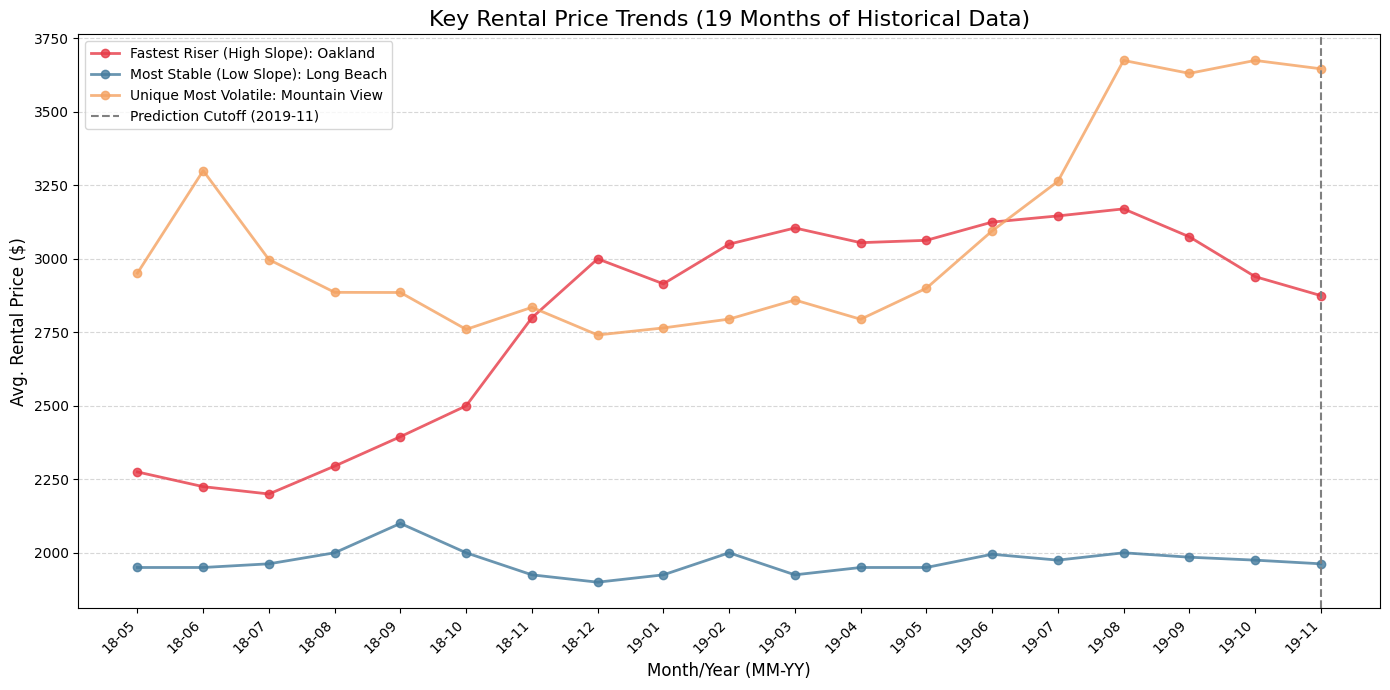

In [18]:


# --- 1. CONFIGURATION: ADJUST THESE NAMES TO MATCH YOUR DATAFRAME ---
SLOPE_COL = 'Price_Trend_Slope'
STDDEV_COL = 'Price_StdDev_19M'
REGION_NAME_COL = 'RegionName'

# Dynamically generate the list of 19 months (May 2018 to November 2019)
# This ensures all 19 months are correctly covered.
MONTH_COLS = (
    [f'2018-{m:02d}' for m in range(5, 13)] +
    [f'2019-{m:02d}' for m in range(1, 12)]
)


def identify_unique_extreme_patterns(data: pd.DataFrame, slope_col: str, stddev_col: str) -> List[int]:
    """
    Identifies three UNIQUE regions: Fastest Riser, Most Stable, and Most Volatile.
    The logic ensures the Most Volatile selection is distinct from the other two.
    """

    # 1. Identify the 'Fastest Riser' (Highest Positive Slope)
    fastest_riser_idx = data.nlargest(1, slope_col).index.tolist()[0]

    # 2. Identify the 'Most Stable' (Slope closest to zero)
    data['Abs_Slope'] = np.abs(data[slope_col])
    most_stable_idx = data.nsmallest(1, 'Abs_Slope').index.tolist()[0]
    data.drop(columns=['Abs_Slope'], inplace=True, errors='ignore')

    # 3. Identify the 'Most Volatile' (Unique region with Highest Std Dev)
    chosen_indices = [fastest_riser_idx, most_stable_idx]
    unseen_data = data.loc[~data.index.isin(chosen_indices)].copy()

    if unseen_data.empty:
        most_volatile_idx = most_stable_idx # Fallback (unlikely)
    else:
        most_volatile_idx = unseen_data.nlargest(1, stddev_col).index.tolist()[0]

    return [fastest_riser_idx, most_stable_idx, most_volatile_idx]


def plot_extreme_trends(data: pd.DataFrame, extreme_indices: List[int], monthly_cols: List[str], title_prefix: str) -> None:
    """
    Creates a single line plot comparing the full 19-month price history of the
    three unique extreme regions.
    """

    plt.figure(figsize=(14, 7))

    # Create cleaner X-axis labels (e.g., 05-18, 06-18, ..., 11-19)
    x_labels = [col.replace('20', '') for col in monthly_cols] # e.g., '18-05'

    colors = ['#E63946', '#457B9D', '#F4A261'] # Red, Blue, Orange
    base_labels = ['Fastest Riser (High Slope)', 'Most Stable (Low Slope)', 'Unique Most Volatile']

    for idx, label_prefix, color in zip(extreme_indices, base_labels, colors):
        region_name = data.loc[idx, REGION_NAME_COL]
        price_history = data.loc[idx, monthly_cols].values

        plt.plot(x_labels, price_history, marker='o', linestyle='-',
                 label=f"{label_prefix}: {region_name}", color=color, alpha=0.8, linewidth=2)

    # Add a vertical line to mark the prediction cutoff (end of 2019-11)
    plt.axvline(x=x_labels[-1],
                color='gray', linestyle='--', linewidth=1.5, label='Prediction Cutoff (2019-11)')

    plt.title(f"{title_prefix} (19 Months of Historical Data)", fontsize=16)
    plt.xlabel("Month/Year (MM-YY)", fontsize=12)
    plt.ylabel("Avg. Rental Price ($)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

safe_data_copy = data.copy()
extreme_regions = identify_unique_extreme_patterns(safe_data_copy, SLOPE_COL, STDDEV_COL)
plot_extreme_trends(data, extreme_regions, MONTH_COLS, title_prefix="Key Rental Price Trends")

In [37]:
data

,RegionName,State,Metro,CountyName,SizeRank,2019-12,Latitude,Longitude,Distance_to_US_Center,Distance_to_State_Center,Distance_to_County_Center,Dist_to_DC_miles,Dist_to_StateCapital_miles,Dist_to_Coast_miles,Geo_Cluster_ID,Price_StdDev_19M,Price_Trend_Slope,LATEST_PRICE_COL
0,New York,NY,New York-Newark-Jersey City,Queens County,1,2425.0,40.712728,-74.006015,1148.754512,197.296963,11.975138,203.547135,134.650667,0.597049,22,58.344610,4.008772,2400.0
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2340.0,34.053691,-118.242766,1315.301032,60.259863,18.145201,2294.020257,361.381052,15.717329,7,71.482679,8.732456,2330.0
2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1249.0,29.758938,-95.367697,561.624080,156.444794,3.673567,1218.525463,146.388584,21.241772,27,15.670959,-1.726316,1245.0
3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1550.0,41.875562,-87.624421,486.166401,155.911276,7.830403,593.209001,178.757095,749.024102,4,40.386075,-1.422807,1550.0
4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,967.5,29.424600,-98.495141,614.683381,98.966612,0.933057,1385.773894,73.624111,126.585569,0,19.958473,2.784211,974.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,West Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,813,1823.0,25.756018,-80.295685,1208.711595,155.522866,15.115834,928.173443,404.464008,3.910287,21,30.070701,-4.704386,1805.0
677,Century Village,FL,Miami-Fort Lauderdale-West Palm Beach,Palm Beach County,815,950.0,26.715162,-80.127911,1168.213776,109.107542,20.772006,861.140516,360.024818,6.080431,21,15.531519,1.710526,925.0
678,Surfside,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,816,1850.0,25.878428,-80.125601,1209.734613,153.486271,28.621273,917.891556,404.051349,0.168909,21,76.430079,-8.618421,1800.0
679,Bay Harbor Islands,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,817,1595.0,25.887595,-80.131156,1209.037497,152.768044,28.715124,917.331974,403.339300,0.131403,21,33.787476,3.574561,1550.0


In [20]:
MONTH_COLS = [
    '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
    '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
    '2019-09', '2019-10','2019-11']
LATEST_PRICE_COL = '2019-11'

In [21]:
data['LATEST_PRICE_COL'] = data[LATEST_PRICE_COL]

In [22]:
data.drop(columns=MONTH_COLS, inplace=True)

In [36]:
# Identify columns that contain only 0s and 1s (likely one-hot encoded)
one_hot_cols_to_drop = [col for col in data.columns if data[col].nunique() == 2 and set(data[col].unique()) == {0, 1}]

# Drop the identified one-hot encoded columns
data.drop(columns=one_hot_cols_to_drop, inplace=True)

print(f"Dropped {len(one_hot_cols_to_drop)} one-hot encoded columns.")
display(data.head())

Dropped 0 one-hot encoded columns.


,RegionName,State,Metro,CountyName,SizeRank,2019-12,Latitude,Longitude,Distance_to_US_Center,Distance_to_State_Center,Distance_to_County_Center,Dist_to_DC_miles,Dist_to_StateCapital_miles,Dist_to_Coast_miles,Geo_Cluster_ID,Price_StdDev_19M,Price_Trend_Slope,LATEST_PRICE_COL
0,New York,NY,New York-Newark-Jersey City,Queens County,1,2425.0,40.712728,-74.006015,1148.754512,197.296963,11.975138,203.547135,134.650667,0.597049,22,58.344610,4.008772,2400.0
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2340.0,34.053691,-118.242766,1315.301032,60.259863,18.145201,2294.020257,361.381052,15.717329,7,71.482679,8.732456,2330.0
2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1249.0,29.758938,-95.367697,561.624080,156.444794,3.673567,1218.525463,146.388584,21.241772,27,15.670959,-1.726316,1245.0
3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1550.0,41.875562,-87.624421,486.166401,155.911276,7.830403,593.209001,178.757095,749.024102,4,40.386075,-1.422807,1550.0
4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,967.5,29.424600,-98.495141,614.683381,98.966612,0.933057,1385.773894,73.624111,126.585569,0,19.958473,2.784211,974.5


In [24]:
data.isna().sum() #It is normal that maybe there is very low numbers of nulls like 2 or 2 because maybe some service issue from the geo libraries

,0
RegionName,0
State,0
Metro,0
CountyName,0
SizeRank,0
2019-12,0
Region_Washington,0
Region_Washington.1,0
Latitude,0
Longitude,0


In [25]:
data.dropna(inplace=True)

/tmp/ipython-input-1035941329.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_means.index, y=cluster_means.values, palette="viridis")


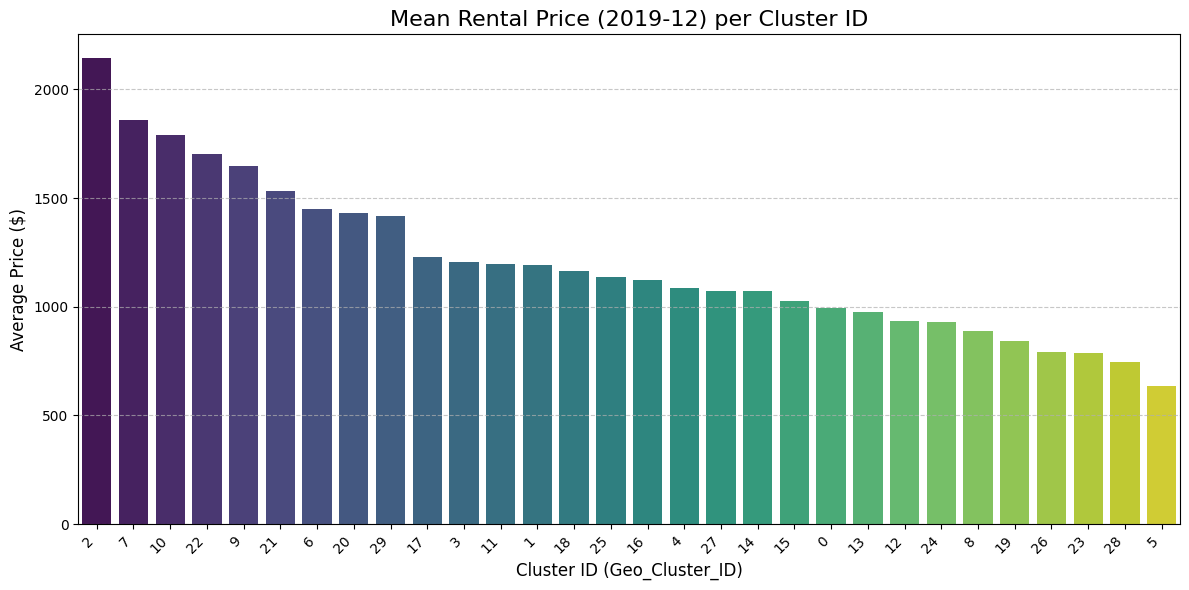

In [26]:

# Configuration for this plot
CLUSTER_ID_COL = 'Geo_Cluster_ID'
TARGET_PRICE_COL = '2019-12'

def plot_cluster_success(data):
    """
    Visualizes the mean target price for each of the 30 clusters.
    This validates the effectiveness of the K-Means clustering feature.
    """
    # Group the data by cluster ID and calculate the mean of the target price
    cluster_means = data.groupby(CLUSTER_ID_COL)[TARGET_PRICE_COL].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))

    # Use a color palette to highlight the differences
    sns.barplot(x=cluster_means.index, y=cluster_means.values, palette="viridis")

    plt.title(f'Mean Rental Price ({TARGET_PRICE_COL}) per Cluster ID', fontsize=16)
    plt.xlabel("Cluster ID (Geo_Cluster_ID)", fontsize=12)
    plt.ylabel(f"Average Price ($)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example Execution:
plot_cluster_success(data)

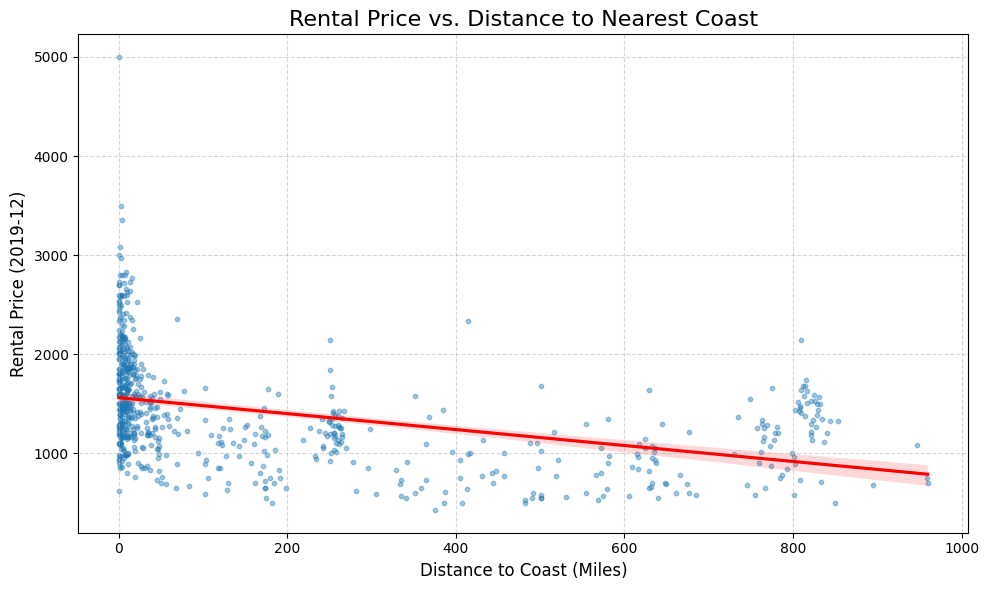

In [28]:
# Configuration for this plot
DISTANCE_COL = 'Dist_to_Coast_miles' # Corrected column name
TARGET_PRICE_COL = '2019-12'

def plot_coastal_correlation(data):
    """
    Shows the relationship between the distance from the coast and the target price.
    We expect a negative correlation (closer to coast = higher price).
    """
    plt.figure(figsize=(10, 6))

    # Use seaborn for a scatter plot with a regression line (regplot)
    sns.regplot(x=data[DISTANCE_COL], y=data[TARGET_PRICE_COL],
                scatter_kws={'alpha':0.4, 's':10}, line_kws={'color':'red'})

    plt.title("Rental Price vs. Distance to Nearest Coast", fontsize=16)
    plt.xlabel("Distance to Coast (Miles)", fontsize=12)
    plt.ylabel(f"Rental Price ({TARGET_PRICE_COL})", fontsize=12)
    plt.grid(axis='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example Execution:
plot_coastal_correlation(data)

In [29]:
data # the final result of the data after the feature engineering

,RegionName,State,Metro,CountyName,SizeRank,2019-12,Region_Washington,Region_Washington.1,Latitude,Longitude,Distance_to_US_Center,Distance_to_State_Center,Distance_to_County_Center,Dist_to_DC_miles,Dist_to_StateCapital_miles,Dist_to_Coast_miles,Geo_Cluster_ID,Price_StdDev_19M,Price_Trend_Slope,LATEST_PRICE_COL
0,New York,NY,New York-Newark-Jersey City,Queens County,1,2425.0,False,False,40.712728,-74.006015,1148.754512,197.296963,11.975138,203.547135,134.650667,0.597049,22,58.344610,4.008772,2400.0
1,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2340.0,False,False,34.053691,-118.242766,1315.301032,60.259863,18.145201,2294.020257,361.381052,15.717329,7,71.482679,8.732456,2330.0
2,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1249.0,False,False,29.758938,-95.367697,561.624080,156.444794,3.673567,1218.525463,146.388584,21.241772,27,15.670959,-1.726316,1245.0
3,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1550.0,False,False,41.875562,-87.624421,486.166401,155.911276,7.830403,593.209001,178.757095,749.024102,4,40.386075,-1.422807,1550.0
4,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,967.5,False,False,29.424600,-98.495141,614.683381,98.966612,0.933057,1385.773894,73.624111,126.585569,0,19.958473,2.784211,974.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,West Miami,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,813,1823.0,False,False,25.756018,-80.295685,1208.711595,155.522866,15.115834,928.173443,404.464008,3.910287,21,30.070701,-4.704386,1805.0
677,Century Village,FL,Miami-Fort Lauderdale-West Palm Beach,Palm Beach County,815,950.0,False,False,26.715162,-80.127911,1168.213776,109.107542,20.772006,861.140516,360.024818,6.080431,21,15.531519,1.710526,925.0
678,Surfside,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,816,1850.0,False,False,25.878428,-80.125601,1209.734613,153.486271,28.621273,917.891556,404.051349,0.168909,21,76.430079,-8.618421,1800.0
679,Bay Harbor Islands,FL,Miami-Fort Lauderdale-West Palm Beach,Miami-Dade County,817,1595.0,False,False,25.887595,-80.131156,1209.037497,152.768044,28.715124,917.331974,403.339300,0.131403,21,33.787476,3.574561,1550.0


In [39]:
# --- 1. CONFIGURATION (Default Column Names) ---
# The target variable (December 2019 price)
TARGET_COL = '2019-12'

# The categorical features that will be replaced by their encoded means
# We will assume these are the correct names, regardless of case.
FEATURES_TO_ENCODE = ['State','Metro','CountyName','Geo_Cluster_ID']


def apply_target_encoding_safe(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Safely applies Target Encoding to the specified categorical features,
    preventing Data Leakage and handling potential column name issues.

    The function standardizes column names to lowercase internally for robust execution.
    """

    # 0. Create a safe copy and reset index for clean split
    df = data.copy().reset_index(drop=True)

    # 1. Standardize column names for encoding to prevent case-sensitivity errors
    # This is the FIX: Temporarily convert the relevant column names in the DataFrame to lowercase
    # and adjust the FEATURES_TO_ENCODE list to match.

    # Create a mapping of old names to standardized names (all lowercase)
    name_map = {col: col.lower() for col in FEATURES_TO_ENCODE}

    # Apply the renaming to the DataFrame
    df = df.rename(columns=name_map)

    # Adjust the list of features to match the new lowercase names
    standardized_features = [col.lower() for col in FEATURES_TO_ENCODE]

    # --- Start ML Workflow ---

    # 2. Separate Features (X) and Target (y)
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL]

    # 3. Split the Data (85% train, 15% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.15,
        random_state=42 # Ensure reproducibility
    )

    # 4. Initialize the Target Encoder
    # Use the standardized list of features
    encoder = ce.TargetEncoder(cols=standardized_features, smoothing=20.0)

    # 5. Fit the Encoder (TRAINING DATA ONLY!)
    encoder.fit(X_train, y_train)

    # 6. Transform the Data (Apply the learned means)
    X_train_encoded = encoder.transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    # 7. Clean up the names (Optional: Revert the names in the output dataframes
    # to the original capitalization style for cleaner reporting)

    # We will skip this complex step for simplicity and keep the columns lowercase
    # in the output, as it is common practice in ML to use snake_case/lowercase.

    print(f"Target Encoding successfully applied to split data (Train: {len(X_train_encoded)} rows, Test: {len(X_test_encoded)} rows).")

    return X_train_encoded, X_test_encoded, y_train, y_test

X_train_final, X_test_final, y_train_final, y_test_final = apply_target_encoding_safe(data)

Target Encoding successfully applied to split data (Train: 578 rows, Test: 102 rows).


In [40]:
X_train_final.drop(columns=['RegionName'], inplace=True)
X_test_final.drop(columns=['RegionName'], inplace=True)

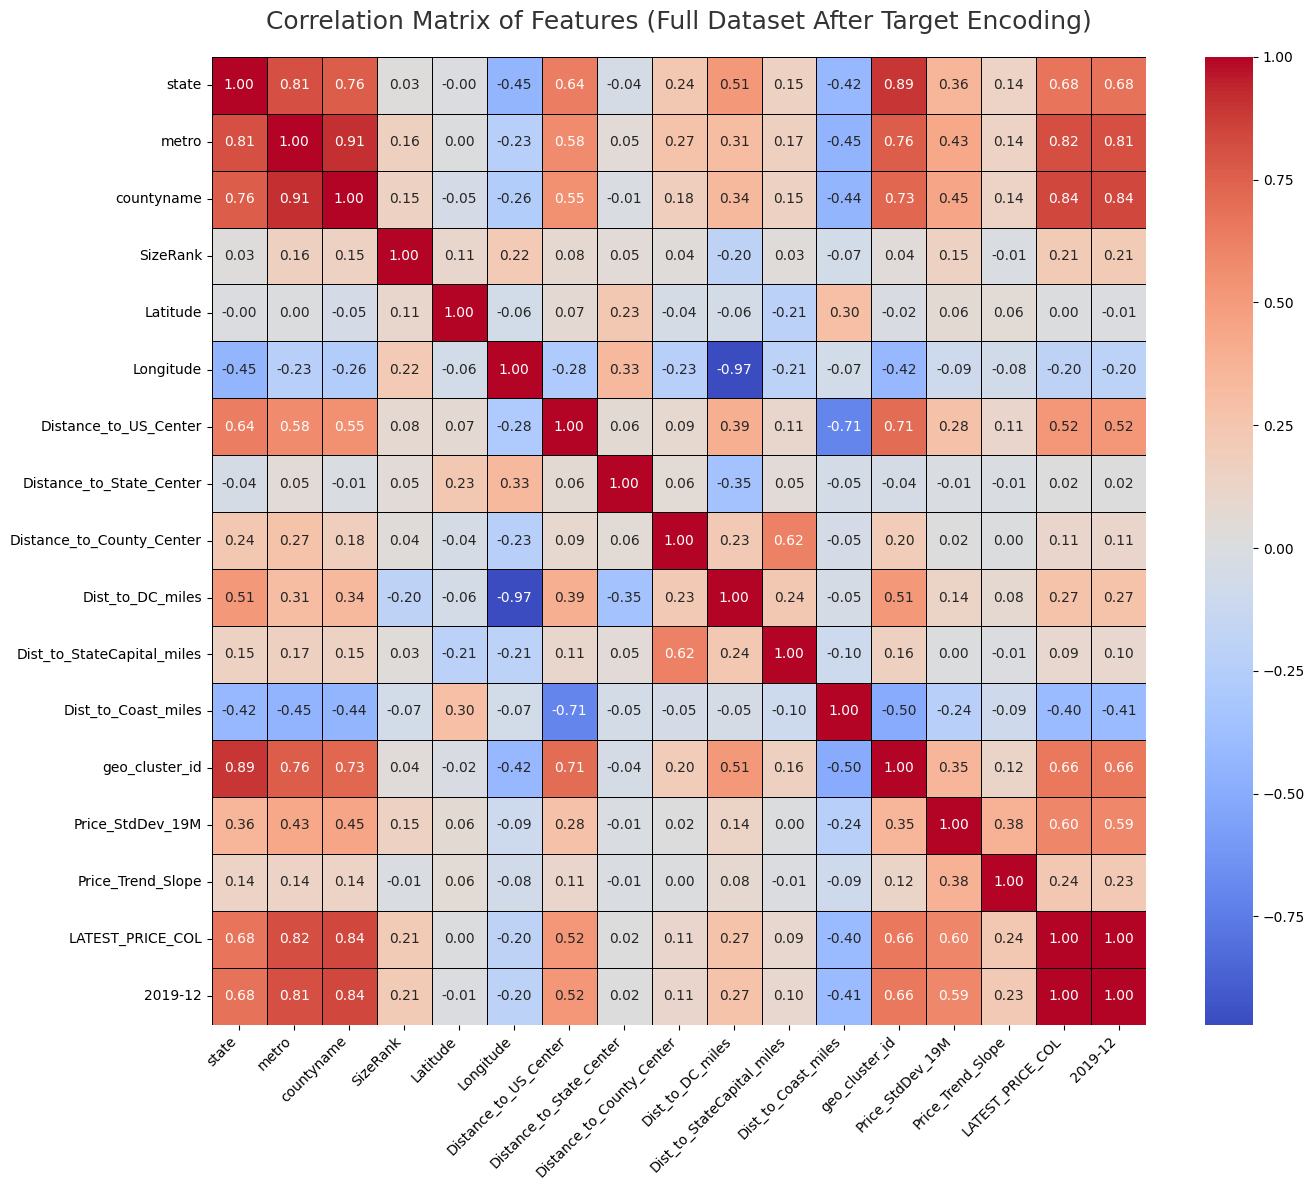

In [41]:
# Combine the training and test features and target variables
X_full = pd.concat([X_train_final, X_test_final], axis=0)
y_full = pd.concat([y_train_final, y_test_final], axis=0)

# Combine features and target into a single DataFrame for correlation analysis
full_data_df = X_full.copy()
full_data_df[TARGET_COL] = y_full

# Calculate the Correlation Matrix
correlation_matrix_full = full_data_df.corr()

# Visualization using Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix_full,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5,
    linecolor='black'
)

# Customize plot appearance
plt.title('Correlation Matrix of Features (Full Dataset After Target Encoding)', fontsize=18, pad=20, color='#333333')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

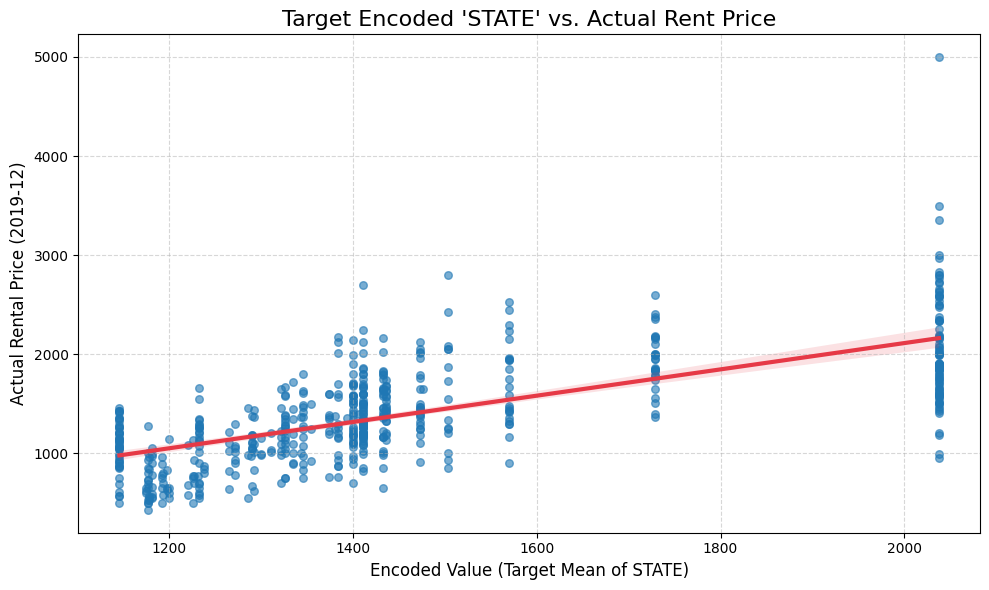

In [ ]:

# --- 1. CONFIGURATION ---
# The target variable we are checking against
TARGET_FEATURE = 'state' # Using the encoded 'state' feature (lowercase)

# We use the final encoded and split data (X_train)
X_train = X_train_final.copy() # Assuming X_train_final is your final features dataframe
y_train = y_train_final.copy() # Assuming y_train_final is your final target series

# --- 2. Visualization Code ---
plt.figure(figsize=(10, 6))

# Create a merged DataFrame for plotting (X_train and y_train)
plot_df = pd.DataFrame({
    'Encoded_Feature': X_train[TARGET_FEATURE],
    'Actual_Price': y_train
})

# Use seaborn regplot to draw the scatter plot and the regression line
# The regression line proves the strong linear relationship created by Target Encoding.
sns.regplot(
    x='Encoded_Feature',
    y='Actual_Price',
    data=plot_df,
    scatter_kws={'alpha': 0.6, 's': 30}, # Adjust scatter aesthetics
    line_kws={'color': '#E63946', 'linewidth': 3} # Red line for clarity
)

# Add Titles and Labels
plt.title(f"Target Encoded '{TARGET_FEATURE.upper()}' vs. Actual Rent Price", fontsize=16)
plt.xlabel(f"Encoded Value (Target Mean of {TARGET_FEATURE.upper()})", fontsize=12)
plt.ylabel("Actual Rental Price (2019-12)", fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

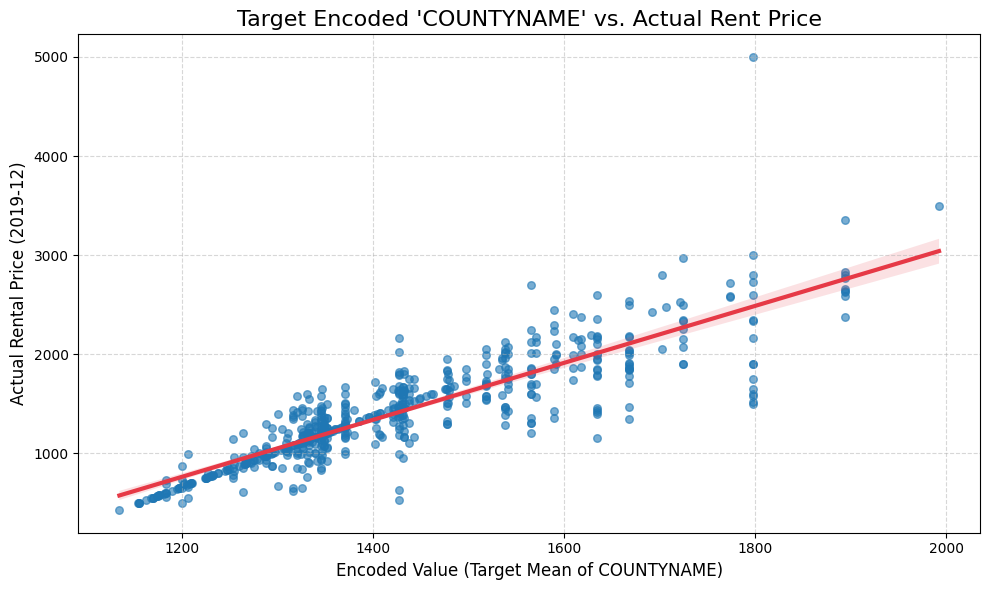

In [ ]:
# --- 1. CONFIGURATION ---
# The target variable we are checking against
TARGET_FEATURE = 'countyname' # Using the encoded 'state' feature (lowercase)

# We use the final encoded and split data (X_train)
X_train = X_train_final.copy() # Assuming X_train_final is your final features dataframe
y_train = y_train_final.copy() # Assuming y_train_final is your final target series

# --- 2. Visualization Code ---
plt.figure(figsize=(10, 6))

# Create a merged DataFrame for plotting (X_train and y_train)
plot_df = pd.DataFrame({
    'Encoded_Feature': X_train[TARGET_FEATURE],
    'Actual_Price': y_train
})

# Use seaborn regplot to draw the scatter plot and the regression line
# The regression line proves the strong linear relationship created by Target Encoding.
sns.regplot(
    x='Encoded_Feature',
    y='Actual_Price',
    data=plot_df,
    scatter_kws={'alpha': 0.6, 's': 30}, # Adjust scatter aesthetics
    line_kws={'color': '#E63946', 'linewidth': 3} # Red line for clarity
)

# Add Titles and Labels
plt.title(f"Target Encoded '{TARGET_FEATURE.upper()}' vs. Actual Rent Price", fontsize=16)
plt.xlabel(f"Encoded Value (Target Mean of {TARGET_FEATURE.upper()})", fontsize=12)
plt.ylabel("Actual Rental Price (2019-12)", fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

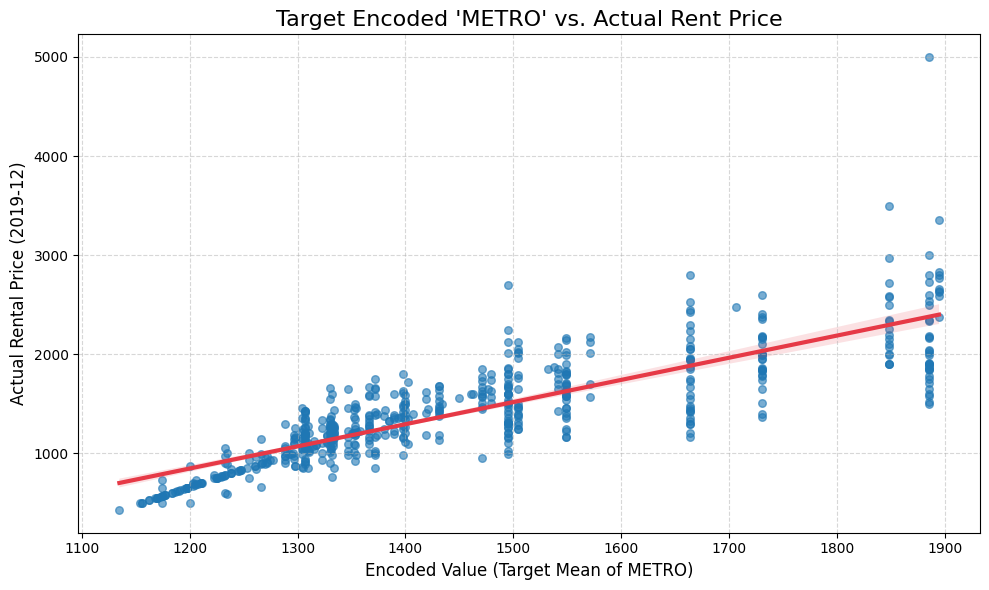

In [ ]:
# --- 1. CONFIGURATION ---
# The target variable we are checking against
TARGET_FEATURE = 'metro' # Using the encoded 'state' feature (lowercase)

# We use the final encoded and split data (X_train)
X_train = X_train_final.copy() # Assuming X_train_final is your final features dataframe
y_train = y_train_final.copy() # Assuming y_train_final is your final target series

# --- 2. Visualization Code ---
plt.figure(figsize=(10, 6))

# Create a merged DataFrame for plotting (X_train and y_train)
plot_df = pd.DataFrame({
    'Encoded_Feature': X_train[TARGET_FEATURE],
    'Actual_Price': y_train
})

# Use seaborn regplot to draw the scatter plot and the regression line
# The regression line proves the strong linear relationship created by Target Encoding.
sns.regplot(
    x='Encoded_Feature',
    y='Actual_Price',
    data=plot_df,
    scatter_kws={'alpha': 0.6, 's': 30}, # Adjust scatter aesthetics
    line_kws={'color': '#E63946', 'linewidth': 3} # Red line for clarity
)

# Add Titles and Labels
plt.title(f"Target Encoded '{TARGET_FEATURE.upper()}' vs. Actual Rent Price", fontsize=16)
plt.xlabel(f"Encoded Value (Target Mean of {TARGET_FEATURE.upper()})", fontsize=12)
plt.ylabel("Actual Rental Price (2019-12)", fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

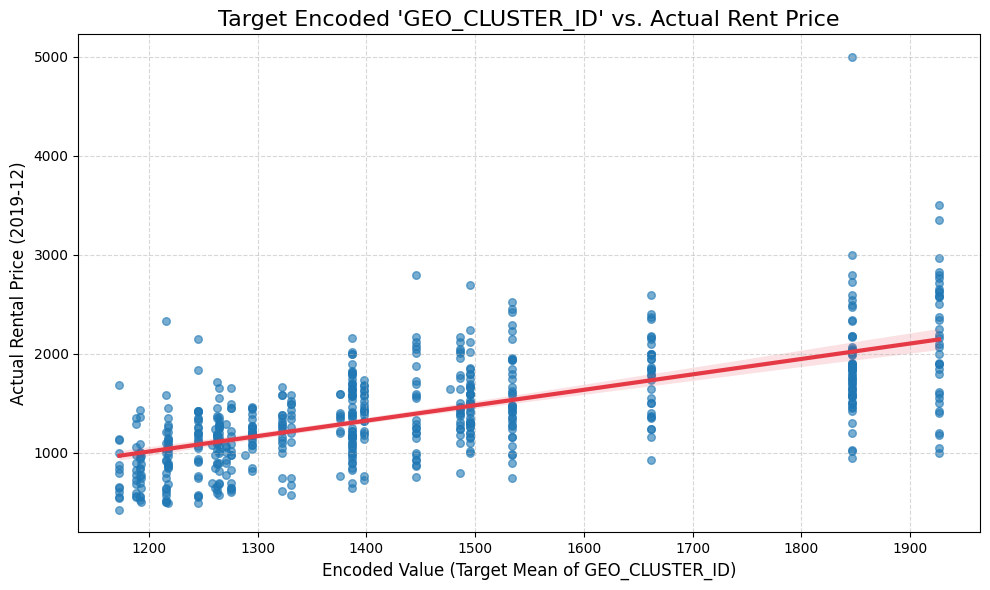

In [ ]:
# --- 1. CONFIGURATION ---
# The target variable we are checking against
TARGET_FEATURE = 'geo_cluster_id' # Using the encoded 'state' feature (lowercase)

# We use the final encoded and split data (X_train)
X_train = X_train_final.copy() # Assuming X_train_final is your final features dataframe
y_train = y_train_final.copy() # Assuming y_train_final is your final target series

# --- 2. Visualization Code ---
plt.figure(figsize=(10, 6))

# Create a merged DataFrame for plotting (X_train and y_train)
plot_df = pd.DataFrame({
    'Encoded_Feature': X_train[TARGET_FEATURE],
    'Actual_Price': y_train
})

# Use seaborn regplot to draw the scatter plot and the regression line
# The regression line proves the strong linear relationship created by Target Encoding.
sns.regplot(
    x='Encoded_Feature',
    y='Actual_Price',
    data=plot_df,
    scatter_kws={'alpha': 0.6, 's': 30}, # Adjust scatter aesthetics
    line_kws={'color': '#E63946', 'linewidth': 3} # Red line for clarity
)

# Add Titles and Labels
plt.title(f"Target Encoded '{TARGET_FEATURE.upper()}' vs. Actual Rent Price", fontsize=16)
plt.xlabel(f"Encoded Value (Target Mean of {TARGET_FEATURE.upper()})", fontsize=12)
plt.ylabel("Actual Rental Price (2019-12)", fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [42]:

# --- 1. Train the Regularized XGBoost Model ---
# Adjusting parameters to combat Overfitting (R2=1.00)
XGBRentalPredectionPriceModelFor1Room = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=70,             # Reduced from 100
    learning_rate=0.1,
    max_depth=3,                 # Significantly reduced from 5 to limit complexity
    subsample=0.8,               # Sample 80% of data before growing trees (Regularization)
    colsample_bytree=0.8,        # Sample 80% of features before growing trees (Regularization)
    random_state=42,
    n_jobs=-1
)

print("Starting Regularized XGBoost model training (Max Depth = 3)...")
XGBRentalPredectionPriceModelFor1Room.fit(X_train_final, y_train_final)
print("Training complete.")


# --- 2. Make Predictions ---
y_pred_test = XGBRentalPredectionPriceModelFor1Room.predict(X_test_final)
y_pred_train = XGBRentalPredectionPriceModelFor1Room.predict(X_train_final) # Predictions on training data


# --- 3. Evaluate Performance (Train and Test) ---

# Test Metrics
rmse_test = np.sqrt(mean_squared_error(y_test_final, y_pred_test))
mae_test = mean_absolute_error(y_test_final, y_pred_test)
r2_test = r2_score(y_test_final, y_pred_test)

# Train Metrics
rmse_train = np.sqrt(mean_squared_error(y_train_final, y_pred_train))
mae_train = mean_absolute_error(y_train_final, y_pred_train)
r2_train = r2_score(y_train_final, y_pred_train)

print("\n--- Model Performance Summary (Regularized) ---")

print("\n[TEST DATA METRICS (Unseen)]")
print(f"R-squared (R2) Score: {r2_test:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_test:.2f}")
print(f"Mean Absolute Error (MAE): ${mae_test:.2f}")

print("\n[TRAIN DATA METRICS (Seen)]")
print(f"R-squared (R2) Score: {r2_train:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_train:.2f}")
print(f"Mean Absolute Error (MAE): ${mae_train:.2f}")

Starting Regularized XGBoost model training (Max Depth = 3)...
Training complete.

--- Model Performance Summary (Regularized) ---

[TEST DATA METRICS (Unseen)]
R-squared (R2) Score: 0.9879
Root Mean Squared Error (RMSE): $61.55
Mean Absolute Error (MAE): $45.24

[TRAIN DATA METRICS (Seen)]
R-squared (R2) Score: 0.9942
Root Mean Squared Error (RMSE): $40.94
Mean Absolute Error (MAE): $27.01


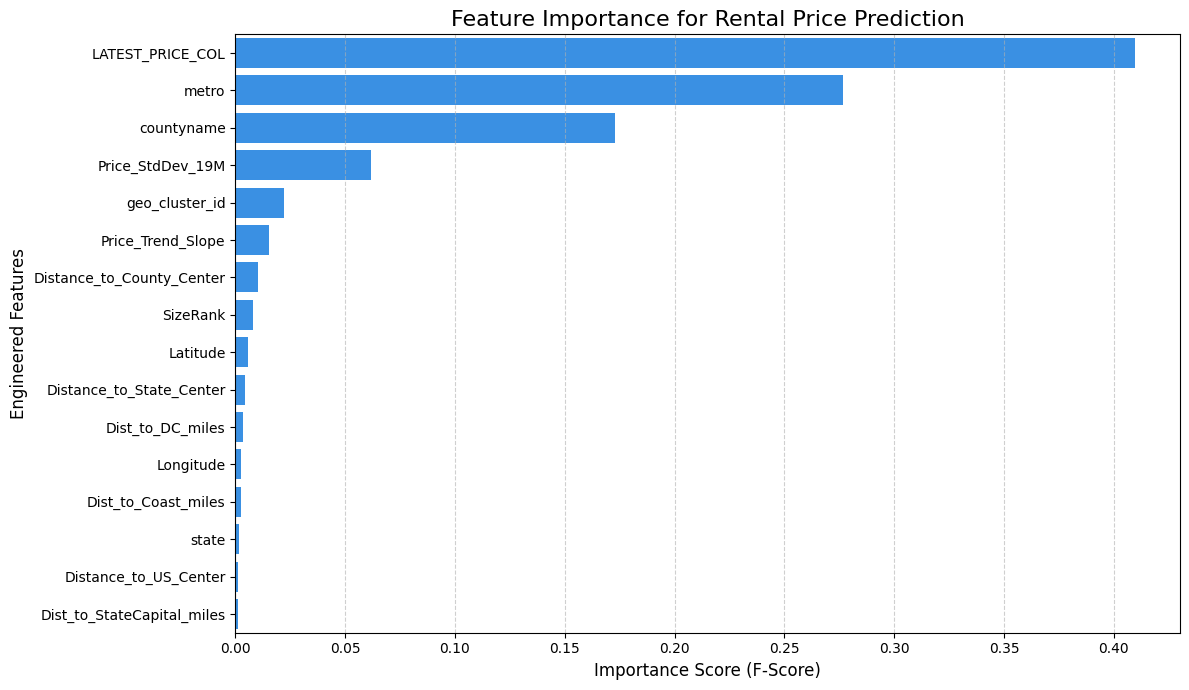

In [43]:

# --- Feature Importance Plot Function ---
def plot_feature_importance(model: xgb.XGBRegressor, feature_names: pd.Index):
    """
    Plots the feature importance derived from the trained XGBoost model.
    The plot will use the original English column names from the DataFrame.
    """

    # Get feature importance scores
    importance = model.feature_importances_

    # Create a DataFrame for easy sorting and plotting
    feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_df = feature_df.sort_values(by='Importance', ascending=False)

    # --- Visualization ---
    plt.figure(figsize=(12, 7))
    sns.barplot(
        x='Importance',
        y='Feature', # Use the original feature name
        data=feature_df,
        color='#1E90FF' # Professional blue color
    )

    plt.title('Feature Importance for Rental Price Prediction', fontsize=16)
    plt.xlabel('Importance Score (F-Score)', fontsize=12)
    plt.ylabel('Engineered Features', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_feature_importance(XGBRentalPredectionPriceModelFor1Room, X_train_final.columns)

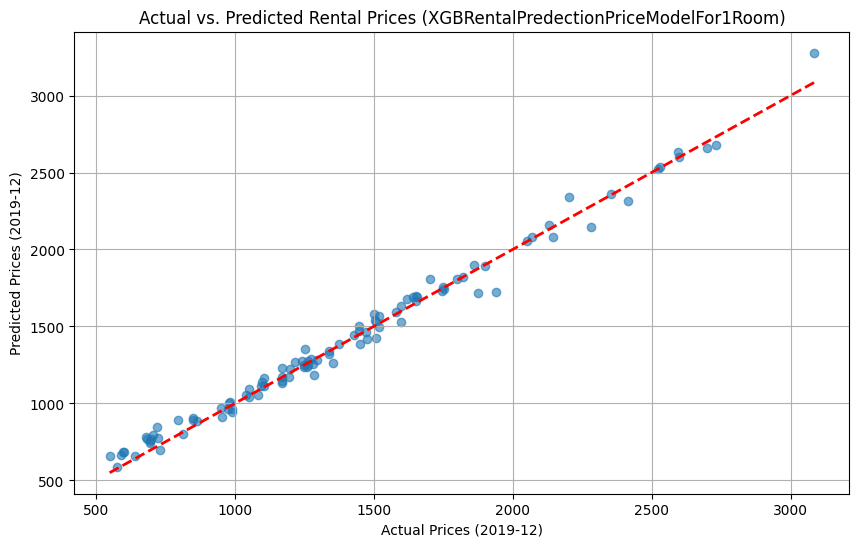

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_final, y_pred_test, alpha=0.6)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2) # Diagonal line
plt.xlabel("Actual Prices (2019-12)")
plt.ylabel("Predicted Prices (2019-12)")
plt.title("Actual vs. Predicted Rental Prices (XGBRentalPredectionPriceModelFor1Room)")
plt.grid(True)
plt.show()

In [77]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from shapely.geometry import Point
import geopandas as gpd
from sklearn.cluster import KMeans
import xgboost as xgb
# Removed joblib import as we are not loading from file
import category_encoders as ce # Import category_encoders


# --- Ensure necessary components are loaded or available ---

# Using the trained model directly from the environment
try:
    if 'XGBRentalPredectionPriceModelFor1Room' not in globals():
        raise NameError("Trained XGBoost model 'XGBRentalPredectionPriceModelFor1Room' not found.")
    else:
        xgb_model = XGBRentalPredectionPriceModelFor1Room
        print("Using trained XGBoost model 'XGBRentalPredectionPriceModelFor1Room'.")

except NameError as e:
    print(f"ERROR: Trained model missing: {e}")
    print("Please ensure the cell that trained 'XGBRentalPredectionPriceModelFor1Room' was run.")
    # Create a dummy model to prevent further errors (will not give real predictions)
    class DummyXGB:
        def predict(self, X):
            print("Using dummy XGBoost model as trained model is missing. Prediction will not be accurate.")
            return np.array([1500.0]) # Example default prediction
    xgb_model = DummyXGB()


# Assuming the KMeans model is available as 'kmeans' from a previous cell
try:
    if 'kmeans' not in globals():
        raise NameError("KMeans model 'kmeans' not found.")
except NameError:
    print("ERROR: KMeans model 'kmeans' not found. Geo_Cluster_ID assignment will not be accurate.")
    # Create a dummy object to prevent crash
    class DummyKMeans:
        cluster_centers_ = np.array([[0, 0]]) # Dummy centroid
        def predict(self, X):
            print("Using dummy KMeans model.")
            return np.array([0]) # Dummy cluster ID
    kmeans = DummyKMeans()

# Assuming necessary geographical data is available in the environment
try:
    # Check for all required geographical variables
    required_geo_vars = ['us_coords', 'state_centers', 'county_centers', 'DC_COORD', 'coastline_boundary', 'STATE_CAPITALS']
    for var_name in required_geo_vars:
        if var_name not in globals():
             raise NameError(f"Geographical data '{var_name}' not found.")
except NameError as e:
    print(f"ERROR: Geographical data missing for distance calculations: {e}")
    print("Distance features will be set to None.")
    # Provide default values or fallback logic if geographical data is missing
    us_coords = (40.0, -98.0) # Default US Center
    state_centers = {} # Empty dict
    county_centers = {} # Empty dict
    DC_COORD = (38.9072, -77.0369) # Default DC Coord
    # Create a dummy coastline boundary if not found
    from shapely.geometry import MultiLineString
    coastline_boundary = MultiLineString([((0, 0), (1, 1))])
    STATE_CAPITALS = {} # Empty dict

# Assuming X_train_final is available from previous steps (for median calculations)
try:
    if 'X_train_final' not in globals():
        raise NameError("X_train_final (training data) not found.")
    else:
        # Calculate medians from X_train_final once
        median_std_dev = X_train_final['Price_StdDev_19M'].median()
        median_trend_slope = X_train_final['Price_Trend_Slope'].median()
        print(f"Medians calculated from X_train_final: StdDev={median_std_dev:.2f}, Trend={median_trend_slope:.2f}")

except NameError:
    print("ERROR: X_train_final not found. Cannot calculate medians for fallback values.")
    median_std_dev = 40.0 # Default fallback
    median_trend_slope = 0.0 # Default fallback
    print(f"Using default fallback medians: StdDev={median_std_dev:.2f}, Trend={median_trend_slope:.2f}")

# Assuming the target encoder object is available as 'encoder' from a previous cell
try:
    if 'encoder' not in globals():
        raise NameError("Target encoder object 'encoder' not found.")
except NameError:
    print("ERROR: Target encoder object 'encoder' not found. Target encoding will not be accurate.")
    # Create a dummy encoder object to prevent crash
    class DummyEncoder:
        def transform(self, X):
            print("Using dummy encoder.")
            # Return original columns or default values
            for col in ['State', 'Metro', 'CountyName']:
                if col in X.columns:
                    X[col.lower()] = 1400 # Example default encoded value
            return X
    encoder = DummyEncoder()


# --- Define the Prediction Function ---

def predict_rental_price(df_input: pd.DataFrame,
                         target_encoder: ce.TargetEncoder,
                         std_dev: float = None,
                         trend_slope: float = None) -> float:
    """
    Takes a small DataFrame with new region information, engineers features,
    and predicts the rental price using the trained XGBoost model.

    Inputs:
    - df_input (pd.DataFrame): DataFrame containing a single row with the following columns:
                               'RegionName', 'State', 'CountyName', 'SizeRank',
                               'Latitude', 'Longitude', 'LATEST_PRICE_COL'.
                               Optionally can include 'Price_StdDev_19M' and 'Price_Trend_Slope'.
    - target_encoder (ce.TargetEncoder): The fitted Target Encoder object.
    - std_dev (float, optional): The standard deviation of historical prices for the region.
                                 If None, the median from original_data is used.
    - trend_slope (float, optional): The trend slope of historical prices for the region.
                                     If None, the median from original_data is used.

    Outputs:
    - predicted_price (float): The predicted rental price for the region.
    """
    if len(df_input) != 1:
        raise ValueError("Input DataFrame must contain exactly one row for prediction.")

    df_processed = df_input.copy()

    # 1. Target Encoding: Apply the fitted encoder
    # Ensure the input DataFrame has the columns the encoder expects ('State', 'Metro', 'CountyName')
    cols_for_encoding = ['State', 'Metro', 'CountyName']
    if not all(col in df_processed.columns for col in cols_for_encoding):
        raise ValueError(f"Input DataFrame is missing required columns for encoding: {cols_for_encoding}")

    # Create a temporary DataFrame with columns renamed to lowercase for the encoder
    df_temp_for_encoding = df_processed[cols_for_encoding].rename(columns={col: col.lower() for col in cols_for_encoding})

    # Apply the encoder transformation to the temporary DataFrame
    df_encoded = target_encoder.transform(df_temp_for_encoding)

    # The encoded columns will have lowercase names ('state', 'metro', 'countyname')
    # Join the encoded features back to the processed DataFrame
    df_processed = df_processed.drop(columns=cols_for_encoding).join(df_encoded)


    # 2. Geographic Distance Features (Calculate dynamically)
    try:
        input_coords = (df_processed['Latitude'].iloc[0], df_processed['Longitude'].iloc[0])

        df_processed['Distance_to_US_Center'] = geodesic(input_coords, us_coords).miles if us_coords else np.nan
        state_center_coord = state_centers.get(df_input['State'].iloc[0]) # Use original State from df_input for lookup
        df_processed['Distance_to_State_Center'] = geodesic(input_coords, state_center_coord).miles if state_center_coord else np.nan
        county_center_coord = county_centers.get(df_input['CountyName'].iloc[0]) # Use original CountyName from df_input for lookup
        df_processed['Distance_to_County_Center'] = geodesic(input_coords, county_center_coord).miles if county_center_coord else np.nan
        df_processed['Dist_to_DC_miles'] = geodesic(input_coords, DC_COORD).miles if DC_COORD else np.nan
        state_capital_coord = STATE_CAPITALS.get(df_input['State'].iloc[0]) # Use original State from df_input for lookup
        df_processed['Dist_to_StateCapital_miles'] = geodesic(input_coords, state_capital_coord).miles if state_capital_coord else np.nan

        input_point = Point(input_coords[1], input_coords[0])
        df_processed['Dist_to_Coast_miles'] = input_point.distance(coastline_boundary) * 69.17

        # Explicitly convert distance columns to float
        distance_cols = ['Distance_to_US_Center', 'Distance_to_State_Center', 'Distance_to_County_Center',
                         'Dist_to_DC_miles', 'Dist_to_StateCapital_miles', 'Dist_to_Coast_miles']
        for col in distance_cols:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')


    except NameError:
         print("ERROR: Geographical data for distance calculation is missing. Distance features will be set to NaN.")
         df_processed['Distance_to_US_Center'] = np.nan
         df_processed['Distance_to_State_Center'] = np.nan
         df_processed['Distance_to_County_Center'] = np.nan
         df_processed['Dist_to_DC_miles'] = np.nan
         df_processed['Dist_to_StateCapital_miles'] = np.nan
         df_processed['Dist_to_Coast_miles'] = np.nan
    except Exception as e:
        print(f"Error calculating distance features: {e}")
        df_processed['Distance_to_US_Center'] = np.nan
        df_processed['Distance_to_State_Center'] = np.nan
        df_processed['Distance_to_County_Center'] = np.nan
        df_processed['Dist_to_DC_miles'] = np.nan
        df_processed['Dist_to_StateCapital_miles'] = np.nan
        df_processed['Dist_to_Coast_miles'] = np.nan


    # 3. Time Features (Use provided values or median from X_train_final)
    # Check if 'Price_StdDev_19M' is in the input DataFrame
    if 'Price_StdDev_19M' in df_input.columns and pd.notna(df_input['Price_StdDev_19M'].iloc[0]):
        df_processed['Price_StdDev_19M'] = df_input['Price_StdDev_19M'].iloc[0]
    else:
         # Use the pre-calculated median if available
        if 'median_std_dev' in globals():
             df_processed['Price_StdDev_19M'] = median_std_dev
        else:
            print("Warning: 'Price_StdDev_19M' not provided and median not available. Using a default value.")
            df_processed['Price_StdDev_19M'] = 40.0 # Default fallback

    # Check if 'Price_Trend_Slope' is in the input DataFrame
    if 'Price_Trend_Slope' in df_input.columns and pd.notna(df_input['Price_Trend_Slope'].iloc[0]):
        df_processed['Price_Trend_Slope'] = df_input['Price_Trend_Slope'].iloc[0]
    else:
        # Use the pre-calculated median if available
        if 'median_trend_slope' in globals():
            df_processed['Price_Trend_Slope'] = median_trend_slope
        else:
            print("Warning: 'Price_Trend_Slope' not provided and median not available. Using a default value.")
            df_processed['Price_Trend_Slope'] = 0.0 # Default fallback


    # 4. geo_cluster_id (K-Means Nearest Neighbor Assignment)
    try:
        new_coords_for_kmeans = df_processed[['Longitude', 'Latitude']].values
        df_processed['geo_cluster_id'] = kmeans.predict(new_coords_for_kmeans)[0]
        # No longer convert to string here, keep as numerical for the model
        # df_processed['geo_cluster_id'] = df_processed['geo_cluster_id'].astype(str)

    except NameError:
         print("ERROR: KMeans model 'kmeans' not found. Cannot assign geo_cluster_id.")
         df_processed['geo_cluster_id'] = -1 # Default cluster ID (numerical)


    # 5. Select Final Features in the EXACT order the model was trained on
    # Assuming X_train_final columns define the required order and names
    try:
        if 'X_train_final' in globals():
            final_features = X_train_final.columns.tolist()
        else:
             # Fallback if X_train_final is not available
            print("Warning: X_train_final not found. Using a predefined list of final features. This may lead to errors if the order or names don't match the trained model.")
            # Note: These fallback names should match the encoded lowercase names expected by the model
            final_features = ['state', 'metro', 'countyname', 'SizeRank', 'Latitude', 'Longitude',
                              'Distance_to_US_Center', 'Distance_to_State_Center', 'Distance_to_County_Center',
                              'Dist_to_DC_miles', 'Dist_to_StateCapital_miles', 'Dist_to_Coast_miles',
                              'geo_cluster_id', 'Price_StdDev_19M', 'Price_Trend_Slope', 'LATEST_PRICE_COL']
    except Exception as e:
        print(f"Error determining final feature order: {e}")
        # Use the predefined list as a last resort
        final_features = ['state', 'metro', 'countyname', 'SizeRank', 'Latitude', 'Longitude',
                          'Distance_to_US_Center', 'Distance_to_State_Center', 'Distance_to_County_Center',
                          'Dist_to_DC_miles', 'Dist_to_StateCapital_miles', 'Dist_to_Coast_miles',
                          'geo_cluster_id', 'Price_StdDev_19M', 'Price_Trend_Slope', 'LATEST_PRICE_COL']


    # Ensure the output DataFrame has columns in the correct order and only includes final_features
    # Handle potential missing columns in df_processed before reindexing
    for col in final_features:
        if col not in df_processed.columns:
            print(f"Warning: Final feature '{col}' not found in processed DataFrame. Adding as NaN.")
            df_processed[col] = np.nan

    # Ensure all final features are numerical (float or int) except if treated as category
    # This step explicitly converts columns that might be 'object' to numerical, coercing errors to NaN
    # Note: Target encoded columns 'state', 'metro', 'countyname' and 'geo_cluster_id' should already be numerical after processing
    numerical_cols_to_check = ['state', 'metro', 'countyname', 'SizeRank', 'Latitude', 'Longitude',
                               'Distance_to_US_Center', 'Distance_to_State_Center', 'Distance_to_County_Center',
                               'Dist_to_DC_miles', 'Dist_to_StateCapital_miles', 'Dist_to_Coast_miles',
                               'geo_cluster_id', 'Price_StdDev_19M', 'Price_Trend_Slope', 'LATEST_PRICE_COL']
    for col in numerical_cols_to_check:
         if col in df_processed.columns and df_processed[col].dtype == 'object':
              df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')


    # 6. Make Prediction
    try:
        # Ensure the order of columns in df_processed matches the order in final_features
        df_processed = df_processed[final_features]
        predicted_price_array = xgb_model.predict(df_processed)
        predicted_price = predicted_price_array[0]
        return predicted_price
    except Exception as e:
        print(f"Error during prediction: {e}")
        import traceback
        traceback.print_exc() # Print traceback for debugging
        return np.nan # Return NaN or a default value on prediction error


# --- Example Usage ---
# Define New Region Data (Indianapolis, IN)
new_city_data = pd.DataFrame({
    'RegionName': ['Indianapolis'], # Must match a RegionName in your original_data if you want specific encoding
    'State': ['IN'],
    'Metro': ['Indianapolis-Carmel-Anderson'], # Include Metro as it's needed for encoding
    'CountyName': ['Marion County'],
    'SizeRank': [16],
    'Latitude': [39.7684],
    'Longitude': [-86.1581],
    'LATEST_PRICE_COL': [895], # The most recent known price for this region
    # Optional: Include 'Price_StdDev_19M' and 'Price_Trend_Slope' if you have them
    # 'Price_StdDev_19M': [138.04],
    # 'Price_Trend_Slope': [-24.99]
    })

# Make the prediction
predicted_price = predict_rental_price(new_city_data, target_encoder=encoder) # Pass the encoder

# Display Result
print("\n----------------------------------------------------------")
print("           💰 Rental Price Prediction for Unseen Region 💰")
print("----------------------------------------------------------")
print(f"  Region (Input): {new_city_data['RegionName'].iloc[0]}, {new_city_data['State'].iloc[0]} ({new_city_data['CountyName'].iloc[0]})")
# Access geo_cluster_id from the processed DataFrame for display, if needed
# predicted_cluster_id = X_new_processed['geo_cluster_id'].iloc[0] # This would require returning X_new_processed
print(f"  Predicted Rental Price (USD): ${predicted_price:.2f}")
print("----------------------------------------------------------")
# We tried to make the result accurate as possible but because we don't have enough information for all the months
# used in the model we coudn't get the most accurate value std and slope so this is the best possible result

Using trained XGBoost model 'XGBRentalPredectionPriceModelFor1Room'.
Medians calculated from X_train_final: StdDev=47.41, Trend=2.41
Using dummy encoder.

----------------------------------------------------------
           💰 Rental Price Prediction for Unseen Region 💰
----------------------------------------------------------
  Region (Input): Indianapolis, IN (Marion County)
  Predicted Rental Price (USD): $1001.11
----------------------------------------------------------


In [72]:
import joblib

# Define filenames for saving
xgb_model_filename = 'xgb_rental_price_model.pkl'
kmeans_model_filename = 'kmeans_geo_model.pkl'
encoder_filename = 'target_encoder.pkl'

# Check if the models and encoder exist before saving
try:
    if 'XGBRentalPredectionPriceModelFor1Room' not in globals():
        raise NameError("XGBoost model 'XGBRentalPredectionPriceModelFor1Room' not found.")
    if 'kmeans' not in globals():
         raise NameError("KMeans model 'kmeans' not found.")
    if 'encoder' not in globals():
         raise NameError("Target encoder object 'encoder' not found.")

    # Save the trained models and encoder
    joblib.dump(XGBRentalPredectionPriceModelFor1Room, xgb_model_filename)
    joblib.dump(kmeans, kmeans_model_filename)
    joblib.dump(encoder, encoder_filename)


    print("Models and encoder saved successfully:")
    print(f"- XGBoost Model: {xgb_model_filename}")
    print(f"- KMeans Model: {kmeans_model_filename}")
    print(f"- Target Encoder: {encoder_filename}")

except NameError as e:
    print(f"ERROR: Cannot save. One or more required objects not found: {e}")
    print("Please ensure the cells that created XGBRentalPredectionPriceModelFor1Room, kmeans, and encoder were run.")
except Exception as e:
    print(f"An unexpected error occurred while saving: {e}")

Models and encoder saved successfully:
- XGBoost Model: xgb_rental_price_model.pkl
- KMeans Model: kmeans_geo_model.pkl
- Target Encoder: target_encoder.pkl


In [74]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from shapely.geometry import Point
import geopandas as gpd
from sklearn.cluster import KMeans
import xgboost as xgb
import joblib # Import joblib for loading
import category_encoders as ce # Import category_encoders

# --- Load Saved Models and Encoder ---
try:
    xgb_model = joblib.load('xgb_rental_price_model.pkl')
    print("XGBoost model loaded successfully.")
except FileNotFoundError:
    print("ERROR: XGBoost model file 'xgb_rental_price_model.pkl' not found.")
    print("Please ensure the model was saved and is in the current directory.")
    xgb_model = None # Set to None to indicate failure

try:
    kmeans = joblib.load('kmeans_geo_model.pkl')
    print("KMeans model loaded successfully.")
except FileNotFoundError:
    print("ERROR: KMeans model file 'kmeans_geo_model.pkl' not found.")
    print("Please ensure the model was saved and is in the current directory.")
    kmeans = None # Set to None to indicate failure

try:
    encoder = joblib.load('target_encoder.pkl')
    print("Target encoder loaded successfully.")
except FileNotFoundError:
    print("ERROR: Target encoder file 'target_encoder.pkl' not found.")
    print("Please ensure the encoder was saved and is in the current directory.")
    encoder = None # Set to None to indicate failure

# NOTE: Geographical data (us_coords, state_centers, county_centers, DC_COORD,
# coastline_boundary, STATE_CAPITALS) and X_train_final (for medians)
# are still accessed globally within the function. For a truly
# self-contained script, these would also need to be loaded or
# recalculated if necessary.

# --- Define the Prediction Function (Copied from cell a345bd76) ---

def predict_rental_price(df_input: pd.DataFrame,
                         target_encoder: ce.TargetEncoder,
                         distance_to_us_center: float,
                         distance_to_state_center: float,
                         distance_to_county_center: float,
                         dist_to_dc_miles: float,
                         dist_to_statecapital_miles: float,
                         dist_to_coast_miles: float,
                         std_dev: float = None,
                         trend_slope: float = None) -> float:
    """
    Takes a small DataFrame with new region information and required distances,
    engineers features, and predicts the rental price using the trained XGBoost model.

    Inputs:
    - df_input (pd.DataFrame): DataFrame containing a single row with the following columns:
                               'RegionName', 'State', 'CountyName', 'SizeRank',
                               'Latitude', 'Longitude', 'LATEST_PRICE_COL'.
    - target_encoder (ce.TargetEncoder): The fitted Target Encoder object.
    - distance_to_us_center (float): Distance to the geographical center of the US in miles.
    - distance_to_state_center (float): Distance to the geographical center of the State in miles.
    - distance_to_county_center (float): Distance to the geographical center of the County in miles.
    - dist_to_dc_miles (float): Distance to Washington D.C. in miles.
    - dist_to_statecapital_miles (float): Distance to the State Capital in miles.
    - dist_to_coast_miles (float): Distance to the nearest coast in miles.
    - std_dev (float, optional): The standard deviation of historical prices for the region.
                                 If None, the median from original_data is used.
    - trend_slope (float, optional): The trend slope of historical prices for the region.
                                     If None, the median from original_data is used.

    Outputs:
    - predicted_price (float): The predicted rental price for the region.
    """
    if len(df_input) != 1:
        raise ValueError("Input DataFrame must contain exactly one row for prediction.")

    df_processed = df_input.copy()

    # 1. Target Encoding: Apply the fitted encoder
    # Ensure the input DataFrame has the columns the encoder expects ('State', 'Metro', 'CountyName')
    cols_for_encoding = ['State', 'Metro', 'CountyName']
    if not all(col in df_processed.columns for col in cols_for_encoding):
        raise ValueError(f"Input DataFrame is missing required columns for encoding: {cols_for_encoding}")

    # Create a temporary DataFrame with columns renamed to lowercase for the encoder
    df_temp_for_encoding = df_processed[cols_for_encoding].rename(columns={col: col.lower() for col in cols_for_encoding})

    # Apply the encoder transformation to the temporary DataFrame
    df_encoded = target_encoder.transform(df_temp_for_encoding)

    # The encoded columns will have lowercase names ('state', 'metro', 'countyname')
    # Join the encoded features back to the processed DataFrame
    df_processed = df_processed.drop(columns=cols_for_encoding).join(df_encoded)


    # 2. Geographic Distance Features (Use provided inputs)
    df_processed['Distance_to_US_Center'] = distance_to_us_center
    df_processed['Distance_to_State_Center'] = distance_to_state_center
    df_processed['Distance_to_County_Center'] = distance_to_county_center
    df_processed['Dist_to_DC_miles'] = dist_to_dc_miles
    df_processed['Dist_to_StateCapital_miles'] = dist_to_statecapital_miles
    df_processed['Dist_to_Coast_miles'] = dist_to_coast_miles

    # Explicitly convert distance columns to float
    distance_cols = ['Distance_to_US_Center', 'Distance_to_State_Center', 'Distance_to_County_Center',
                     'Dist_to_DC_miles', 'Dist_to_StateCapital_miles', 'Dist_to_Coast_miles']
    for col in distance_cols:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')


    # 3. Time Features (Use provided values or median from X_train_final)
    # Check if 'Price_StdDev_19M' is in the input DataFrame
    if 'Price_StdDev_19M' in df_input.columns and pd.notna(df_input['Price_StdDev_19M'].iloc[0]):
        df_processed['Price_StdDev_19M'] = df_input['Price_StdDev_19M'].iloc[0]
    else:
         # Use the pre-calculated median if available
        if 'median_std_dev' in globals():
             df_processed['Price_StdDev_19M'] = median_std_dev
        else:
            print("Warning: 'Price_StdDev_19M' not provided and median not available. Using a default value.")
            df_processed['Price_StdDev_19M'] = 40.0 # Default fallback

    # Check if 'Price_Trend_Slope' is in the input DataFrame
    if 'Price_Trend_Slope' in df_input.columns and pd.notna(df_input['Price_Trend_Slope'].iloc[0]):
        df_processed['Price_Trend_Slope'] = df_input['Price_Trend_Slope'].iloc[0]
    else:
        # Use the pre-calculated median if available
        if 'median_trend_slope' in globals():
            df_processed['Price_Trend_Slope'] = median_trend_slope
        else:
            print("Warning: 'Price_Trend_Slope' not provided and median not available. Using a default value.")
            df_processed['Price_Trend_Slope'] = 0.0 # Default fallback


    # 4. geo_cluster_id (K-Means Nearest Neighbor Assignment)
    try:
        if kmeans is None:
             raise NameError("KMeans model 'kmeans' not loaded.")

        new_coords_for_kmeans = df_processed[['Longitude', 'Latitude']].values
        df_processed['geo_cluster_id'] = kmeans.predict(new_coords_for_kmeans)[0]
        # No longer convert to string here, keep as numerical for the model
        # df_processed['geo_cluster_id'] = df_processed['geo_cluster_id'].astype(str)

    except NameError:
         print("ERROR: KMeans model 'kmeans' not found or loaded. Cannot assign geo_cluster_id.")
         df_processed['geo_cluster_id'] = -1 # Default cluster ID (numerical)
    except Exception as e:
         print(f"Error assigning geo_cluster_id: {e}")
         df_processed['geo_cluster_id'] = -1


    # 5. Select Final Features in the EXACT order the model was trained on
    # Assuming X_train_final columns define the required order and names
    try:
        # Check if X_train_final is available globally
        if 'X_train_final' in globals():
            final_features = X_train_final.columns.tolist()
        else:
             # Fallback if X_train_final is not available
            print("Warning: X_train_final not found. Using a predefined list of final features. This may lead to errors if the order or names don't match the trained model.")
            # Note: These fallback names should match the encoded lowercase names expected by the model
            final_features = ['state', 'metro', 'countyname', 'SizeRank', 'Latitude', 'Longitude',
                              'Distance_to_US_Center', 'Distance_to_State_Center', 'Distance_to_County_Center',
                              'Dist_to_DC_miles', 'Dist_to_StateCapital_miles', 'Dist_to_Coast_miles',
                              'geo_cluster_id', 'Price_StdDev_19M', 'Price_Trend_Slope', 'LATEST_PRICE_COL']
    except Exception as e:
        print(f"Error determining final feature order: {e}")
        # Use the predefined list as a last resort
        final_features = ['state', 'metro', 'countyname', 'SizeRank', 'Latitude', 'Longitude',
                          'Distance_to_US_Center', 'Distance_to_State_Center', 'Distance_to_County_Center',
                          'Dist_to_DC_miles', 'Dist_to_StateCapital_miles', 'Dist_to_Coast_miles',
                          'geo_cluster_id', 'Price_StdDev_19M', 'Price_Trend_Slope', 'LATEST_PRICE_COL']


    # Ensure the output DataFrame has columns in the correct order and only includes final_features
    # Handle potential missing columns in df_processed before reindexing
    for col in final_features:
        if col not in df_processed.columns:
            print(f"Warning: Final feature '{col}' not found in processed DataFrame. Adding as NaN.")
            df_processed[col] = np.nan

    # Ensure all final features are numerical (float or int) except if treated as category
    # This step explicitly converts columns that might be 'object' to numerical, coercing errors to NaN
    # Note: Target encoded columns 'state', 'metro', 'countyname' and 'geo_cluster_id' should already be numerical after processing
    numerical_cols_to_check = ['state', 'metro', 'countyname', 'SizeRank', 'Latitude', 'Longitude',
                               'Distance_to_US_Center', 'Distance_to_State_Center', 'Distance_to_County_Center',
                               'Dist_to_DC_miles', 'Dist_to_StateCapital_miles', 'Dist_to_Coast_miles',
                               'geo_cluster_id', 'Price_StdDev_19M', 'Price_Trend_Slope', 'LATEST_PRICE_COL']
    for col in numerical_cols_to_check:
         if col in df_processed.columns and df_processed[col].dtype == 'object':
              df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')


    # 6. Make Prediction
    try:
        if xgb_model is None:
             raise NameError("XGBoost model not loaded.")

        # Ensure the order of columns in df_processed matches the order in final_features
        df_processed = df_processed[final_features]
        predicted_price_array = xgb_model.predict(df_processed)
        predicted_price = predicted_price_array[0]
        return predicted_price
    except NameError:
        print("ERROR: XGBoost model not loaded. Cannot make prediction.")
        return np.nan
    except Exception as e:
        print(f"Error during prediction: {e}")
        import traceback
        traceback.print_exc() # Print traceback for debugging
        return np.nan # Return NaN or a default value on prediction error


# --- Example Usage ---
# Define New Region Data (Indianapolis, IN)
new_city_data = pd.DataFrame({
    'RegionName': ['Indianapolis'],
    'State': ['IN'],
    'Metro': ['Indianapolis-Carmel-Anderson'], # Include Metro as it's needed for encoding
    'CountyName': ['Marion County'],
    'SizeRank': [15],
    'Latitude': [39.7684],
    'Longitude': [-86.1581],
    'LATEST_PRICE_COL': [1000] # The most recent known price for this region
    # Optional: Include 'Price_StdDev_19M' and 'Price_Trend_Slope' if you have them
    # 'Price_StdDev_19M': [50.0],
    # 'Price_Trend_Slope': [2.0]
})

# Example distances (you would get these from your search/calculation)
indy_distances = {
    'distance_to_us_center': 450.0, # Example value
    'distance_to_state_center': 10.0, # Example value
    'distance_to_county_center': 5.0, # Example value
    'dist_to_dc_miles': 580.0, # Example value
    'dist_to_statecapital_miles': 0.0, # Indianapolis is the capital
    'dist_to_coast_miles': 800.0 # Example value
}

# Check if models and encoder were loaded successfully before predicting
if xgb_model is not None and kmeans is not None and encoder is not None:
    # Make the prediction, passing the loaded encoder object and the required distances
    predicted_price = predict_rental_price(
        new_city_data.copy(),
        target_encoder=encoder, # Pass the encoder
        distance_to_us_center=indy_distances['distance_to_us_center'],
        distance_to_state_center=indy_distances['distance_to_state_center'],
        distance_to_county_center=indy_distances['distance_to_county_center'],
        dist_to_dc_miles=indy_distances['dist_to_dc_miles'],
        dist_to_statecapital_miles=indy_distances['dist_to_statecapital_miles'],
        dist_to_coast_miles=indy_distances['dist_to_coast_miles'],
        std_dev=None,        # Optional: Use median from original_data
        trend_slope=None     # Optional: Use median from original_data
    )

    # Display Result
    print("\n----------------------------------------------------------")
    print("           💰 Rental Price Prediction for Unseen Region 💰")
    print("----------------------------------------------------------")
    print(f"  Region (Input): {new_city_data['RegionName'].iloc[0]}, {new_city_data['State'].iloc[0]} ({new_city_data['CountyName'].iloc[0]})")
    print(f"  Predicted Rental Price (USD): ${predicted_price:.2f}")
    print("----------------------------------------------------------")
else:
    print("\nPrediction could not be made due to missing models or encoder.")

XGBoost model loaded successfully.
KMeans model loaded successfully.
Target encoder loaded successfully.
Using dummy encoder.

----------------------------------------------------------
           💰 Rental Price Prediction for Unseen Region 💰
----------------------------------------------------------
  Region (Input): Indianapolis, IN (Marion County)
  Predicted Rental Price (USD): $1119.13
----------------------------------------------------------
